In [1]:
%%capture
!pip install -U kaleido
!pip install --upgrade plotly

In [2]:
import wandb
import random
import shutil
import numpy as np
import torch

ModuleNotFoundError: No module named 'wandb'

In [3]:
# Set a seed
seed = 42

#np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
import os
import zipfile
import kagglehub

# Download oxfordpets dataset
path = kagglehub.dataset_download("lucasiturriago/oxfordiiitpet-multi-annotators/versions/2")

os.makedirs('./datasets', exist_ok=True)

# Check if the destination folder already exists
if os.path.exists('./datasets'):
    print(f"The destination folder '{'./datasets'}' already exists. It will be overwritten.")
    # Optionally, remove the destination folder if it already exists
    shutil.rmtree('./datasets')

# Copy the contents of the source folder to the destination folder
shutil.copytree(path, './datasets')

In [4]:
config = {"Main_model":"Annot_Harmony_Model","Seg_model":"ResUNet","Activation":"sigmoid","Input size":(512,512,3),"Image size":(512,512),
          "Dataset":"OMA_G_N_B","AMixPre": True,"Dir of dataset":"./datasets/OxfordIIITPet_Multi_Annotators-G_N_B",
          "Batch size":32,"Epochs":15,"Number of classes":2,"Num of annotators":3,"Ground truth train":True,"Ground truth valid":True,"Ground truth test":True,
          "Annotators train":True,"Annotators valid":True,"Annotators test":True,"Single class train":1,"Single class valid":1,"Single class test":1,
          "Num trials": 40}

In [5]:
import os
import re
import glob
import torch
import traceback
from tqdm import tqdm
import torchvision.io
from pathlib import Path
from torchvision.io import ImageReadMode
import torchvision.transforms.functional as TF
from typing import Union, List, Tuple, Optional
from torch.utils.data import Dataset, DataLoader

class Annot_Harmony_Dataset(Dataset):

    def __init__(self,
                 data_dir: Union[str, Path], 
                 image_size: Tuple[int, int], 
                 num_classes: int, 
                 num_annotators: int, 
                 partition: str, 
                 annotators: bool = True, 
                 ground_truth: bool = True, 
                 single_class: Optional[int] = None):

        self.data_dir = Path(data_dir) if isinstance(data_dir, str) else data_dir
        self.image_size = image_size
        self.num_classes = num_classes
        self.num_annotators = num_annotators
        self.partition = partition
        self.annotators = annotators
        self.ground_truth = ground_truth
        self.single_class = single_class
        
        # Create the path for patch images
        patch_path_pattern = os.path.join(self.data_dir, self.partition, 'patches', '*.png')
        patch_files = glob.glob(patch_path_pattern)

        # Sort patch files alphanumerically
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers for proper sorting
            return [int(part) if part.isdigit() else part for part in parts]

        self.patch_files = sorted(patch_files, key=alphanumeric_key)

        self.file_sample = []
        for file in self.patch_files:
            name_file = file.split('/')[-1]
            self.file_sample.append(name_file)

        self.num_samples = len(patch_files)

        # Print the complete path and the number of found patch images
        print(f"Complete path for patches: {patch_path_pattern}")
        print(f"Number of patch files found: {len(patch_files)}")
        
        mask_path_main = os.path.join(self.data_dir, self.partition, 'masks')

        # Initialize a list to hold the masks for each annotator
        list_annotators = [annotator_ for annotator_ in os.listdir(mask_path_main) if os.path.isdir(os.path.join(mask_path_main, annotator_)) and (annotator_ != 'ground_truth')]
        for annotator in list_annotators:
            list_annotations = []
            for class_id in range(self.num_classes):
                mask_path_pattern = os.path.join(self.data_dir, self.partition, 'masks', annotator, f'class_{class_id}', '*.png')
                found_masks = glob.glob(mask_path_pattern)
                found_masks = sorted(found_masks)
                list_annotations.append(found_masks)

                print(f"Mask path for annotator {annotator}, class {class_id}: {mask_path_pattern}")
                print(f"Number of masks found: {len(found_masks)}")

        self.masks_path = []

        # Organize masks by sample, annotator, and class
        for sample in tqdm(self.file_sample, desc="Organize masks"):
            masks_sample = []
            for class_id in range(self.num_classes):
                for annotator in list_annotators:
                    mask_annotation_path = os.path.join(mask_path_main, annotator, f'class_{class_id}', sample)
                    masks_sample.append(mask_annotation_path)
            self.masks_path.append(masks_sample)

        mask_path_main = os.path.join(self.data_dir, self.partition, 'masks', 'ground_truth')

        # Check which classes have ground truth masks
        for class_id in range(self.num_classes):
            masks_sample = []
            mask_path_pattern = os.path.join(mask_path_main, f'class_{class_id}', '*.png')
            found_masks = glob.glob(mask_path_pattern)
            print(f"Original masks path, class {class_id}: {mask_path_pattern}")
            print(f"Number of masks found: {len(found_masks)}")

        self.ground_truth_masks_path = []
        
        # Organize ground truth masks by sample and class
        for sample in tqdm(self.file_sample, desc="Organize gt masks"):
            masks_sample = []
            if self.single_class != None:
                mask_annotation_path = os.path.join(mask_path_main, f'class_{self.single_class}', sample)
                masks_sample.append(mask_annotation_path)
            else:
              for class_id in range(self.num_classes):
                  mask_annotation_path = os.path.join(mask_path_main, f'class_{class_id}', sample)
                  masks_sample.append(mask_annotation_path)
            self.ground_truth_masks_path.append(masks_sample)     
        
    def __len__(self) -> int:
        
        return len(self.file_sample)

    def process_image(self, file_path: Path) -> torch.Tensor:

        img = torchvision.io.decode_image(str(file_path),mode=ImageReadMode.RGB)
        img = TF.resize(img, self.image_size)
        img = img.float() / 255.0
        return img

    def process_masks(self, _mask_paths: List[Path]) -> torch.Tensor:

        masks = torch.zeros(self.num_annotators * self.num_classes, *self.image_size, dtype=torch.float32)

        for i, file_path in enumerate(_mask_paths):
            mask = torchvision.io.decode_image(str(file_path),mode=ImageReadMode.GRAY)
            mask = TF.resize(mask, self.image_size)
            mask = mask.float() / 255.0
            masks[i, ...] = mask

        return masks

    def process_ground_truth(self, mask_paths_: List[Path])  -> torch.Tensor:

        num_classes = 1 if self.single_class is not None else self.num_classes
        ground_truth = torch.zeros(num_classes,*self.image_size, dtype=torch.float32)

        for i, file_path in enumerate(mask_paths_):
            mask = torchvision.io.decode_image(str(file_path),mode=ImageReadMode.GRAY)
            mask = TF.resize(mask, self.image_size)
            mask = mask.float() / 255.0
            ground_truth[i, ...] = mask

        return ground_truth

    def __getitem__(self, idx: int):
    
        if self.annotators and self.ground_truth:

            image = self.process_image(self.patch_files[idx])
            masks = self.process_masks(self.masks_path[idx])
            ground_truth = self.process_ground_truth(self.ground_truth_masks_path[idx])   

            return image, masks, ground_truth

        elif self.annotators == True and self.ground_truth == False:

            image = self.process_image(self.patch_files[idx])
            masks = self.process_masks(self.masks_path[idx])

            return image, masks

        elif self.annotators == False and self.ground_truth == True:

            image = self.process_image(self.patch_files[idx])
            ground_truth = self.process_ground_truth(self.ground_truth_masks_path[idx]) 

            return image, ground_truth

        else:
            
            raise ValueError("Wrong configuration, at least one of annotators or ground_truth must be True")

def Annot_Harmony_DataLoader(
    data_dir: Union[str, Path], 
    batch_size: int, 
    image_size: Tuple[int, int], 
    num_classes: int, 
    num_annotators: int, 
    partition: str, 
    annotators: bool = True, 
    ground_truth: bool = True, 
    single_class: Optional[int] = None,
    num_workers: int = 0,
    prefetch_factor: int = 2,
    pin_memory: bool = True) -> DataLoader:

    # Crear el dataset
    dataset = Annot_Harmony_Dataset(
        data_dir=data_dir,
        image_size=image_size,
        num_classes=num_classes,
        num_annotators=num_annotators,
        partition=partition,
        annotators=annotators,
        ground_truth=ground_truth,
        single_class=single_class)
    
    # Crear y devolver el DataLoader optimizado para GPU
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(partition == 'Train'),  # Mezclar solo si es el conjunto de entrenamiento
        num_workers=num_workers,        # Usar múltiples trabajadores para carga paralela
        pin_memory=pin_memory,          # Acelerar transferencia a GPU
        prefetch_factor=prefetch_factor if num_workers > 0 else None,  # Prefetching solo si hay workers
        persistent_workers=(num_workers > 0))# Mantener los trabajadores vivos entre iteraciones

In [6]:
train_dataset = Annot_Harmony_DataLoader(
    data_dir=config['Dir of dataset'],
    batch_size=config['Batch size'],
    image_size=config['Image size'],
    num_classes=config['Number of classes'],
    num_annotators=config['Num of annotators'],
    partition='Train',
    annotators=config['Annotators train'],
    ground_truth=config['Ground truth train'],
    single_class=config['Single class train'], 
    num_workers=4) 

Complete path for patches: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Train/patches/*.png
Number of patch files found: 1024
Mask path for annotator annotator_2, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Train/masks/annotator_2/class_0/*.png
Number of masks found: 1025
Mask path for annotator annotator_2, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Train/masks/annotator_2/class_1/*.png
Number of masks found: 1025
Mask path for annotator annotator_1, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Train/masks/annotator_1/class_0/*.png
Number of masks found: 1024
Mask path for annotator annotator_1, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Train/masks/annotator_1/class_1/*.png
Number of masks found: 1024
Mask path for annotator annotator_3, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Train/masks/annotator_3/class_0/*.png
Number of masks found: 1024
Mask path for annotator annotator_3, class 1: datasets/OxfordIIITPet_Multi_Annotato

Organize masks: 100%|██████████| 1024/1024 [00:00<00:00, 99037.69it/s]


Original masks path, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Train/masks/ground_truth/class_0/*.png
Number of masks found: 0
Original masks path, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Train/masks/ground_truth/class_1/*.png
Number of masks found: 1024


Organize gt masks: 100%|██████████| 1024/1024 [00:00<00:00, 590130.16it/s]


In [7]:
valid_dataset = Annot_Harmony_DataLoader(
    data_dir=config['Dir of dataset'],
    batch_size=config['Batch size'],
    image_size=config['Image size'],
    num_classes=config['Number of classes'],
    num_annotators=config['Num of annotators'],
    partition='Valid',
    annotators=config['Annotators valid'],
    ground_truth=config['Ground truth valid'],
    single_class=config['Single class valid'], 
    num_workers=4) 

Complete path for patches: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Valid/patches/*.png
Number of patch files found: 256
Mask path for annotator annotator_2, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Valid/masks/annotator_2/class_0/*.png
Number of masks found: 256
Mask path for annotator annotator_2, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Valid/masks/annotator_2/class_1/*.png
Number of masks found: 256
Mask path for annotator annotator_1, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Valid/masks/annotator_1/class_0/*.png
Number of masks found: 256
Mask path for annotator annotator_1, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Valid/masks/annotator_1/class_1/*.png
Number of masks found: 256
Mask path for annotator annotator_3, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Valid/masks/annotator_3/class_0/*.png
Number of masks found: 257
Mask path for annotator annotator_3, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N

Organize masks: 100%|██████████| 256/256 [00:00<00:00, 89568.05it/s]


Original masks path, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Valid/masks/ground_truth/class_0/*.png
Number of masks found: 0
Original masks path, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Valid/masks/ground_truth/class_1/*.png
Number of masks found: 256


Organize gt masks: 100%|██████████| 256/256 [00:00<00:00, 386516.14it/s]


In [8]:
test_dataset = Annot_Harmony_DataLoader(
    data_dir=config['Dir of dataset'],
    batch_size=config['Batch size'],
    image_size=config['Image size'],
    num_classes=config['Number of classes'],
    num_annotators=config['Num of annotators'],
    partition='Test',
    annotators=config['Annotators test'],
    ground_truth=config['Ground truth test'],
    single_class=config['Single class test'], 
    num_workers=4) 

Complete path for patches: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Test/patches/*.png
Number of patch files found: 256
Mask path for annotator annotator_2, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Test/masks/annotator_2/class_0/*.png
Number of masks found: 256
Mask path for annotator annotator_2, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Test/masks/annotator_2/class_1/*.png
Number of masks found: 257
Mask path for annotator annotator_1, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Test/masks/annotator_1/class_0/*.png
Number of masks found: 257
Mask path for annotator annotator_1, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Test/masks/annotator_1/class_1/*.png
Number of masks found: 257
Mask path for annotator annotator_3, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Test/masks/annotator_3/class_0/*.png
Number of masks found: 256
Mask path for annotator annotator_3, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Tes

Organize masks: 100%|██████████| 256/256 [00:00<00:00, 82792.95it/s]


Original masks path, class 0: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Test/masks/ground_truth/class_0/*.png
Number of masks found: 0
Original masks path, class 1: datasets/OxfordIIITPet_Multi_Annotators-G_N_B/Test/masks/ground_truth/class_1/*.png
Number of masks found: 256


Organize gt masks: 100%|██████████| 256/256 [00:00<00:00, 336490.70it/s]


In [9]:
import gc
import torch
import matplotlib.pyplot as plt

def random_sample_visualization(dataset, num_classes, num_annotators, annotators=True, ground_truth=True, single_class=None):

    data_iter = iter(dataset)
    first_batch = next(data_iter)
    
    # Skip to the desired batch and take one batch
    if annotators == True and ground_truth == True:
        # Handle datasets that include ground truth masks
        images, anns_masks, gt_masks = first_batch
        print(f"Images in the batch: {images.shape}, Masks in the batch: {anns_masks.shape}, Ground truth masks in the batch: {gt_masks.shape}")
    elif annotators == True and ground_truth == False:
        gt_masks = None
        images, anns_masks = first_batch
        print(f"Images in the batch: {images.shape}, Masks in the batch: {anns_masks.shape}")
    elif annotators == False and ground_truth == True:
        anns_masks = None
        images, gt_masks = first_batch
        print(f"Images in the batch: {images.shape}, Ground truth masks in the batch: {gt_masks.shape}")
    else:
        raise ValueError("Wrong configuration, at least one of annotators or ground_truth must be True")

    # Select a random sample within the batch
    sample = random.randint(0, images.shape[0]-1)

    # Determine the number of columns for the visualization grid

    columns = [1]
    rows = 1

    if annotators:
        columns.append(anns_masks.shape[1]/num_classes if anns_masks.shape[1]/num_classes <= 7 else 7)
        row_annotators = rows
        rows+=1

    if ground_truth:
        columns.append(gt_masks.shape[1] if gt_masks.shape[1] <= 7 else 7)
        row_ground_truth = rows
        rows+=1

    columns = int(max(columns))

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(rows + 1, columns, hspace=0.2, wspace=0.2)
    axes = [[fig.add_subplot(gs[r, c]) for c in range(columns)] for r in range(rows)]

    # Display the original image for the selected sample
    axes[0][0].set_title('Image',loc='center')
    axes[0][0].imshow(images[sample].permute(1,2,0))  # Show the sample image

    if annotators:

        title_ax = fig.add_subplot(gs[row_annotators, :])
        title_ax.set_title("Masks of segmentation for different annotators and classes",loc='center')
        title_ax.axis('off')  # Ocultar ejes

        annotators_list = []
        while len(annotators_list) < min(num_annotators,columns):
            num = random.randint(0, num_annotators-1)
            if num not in annotators_list:
                annotators_list.append(num)

        classes_list = [random.randint(0, num_classes-1) for _ in range(len(annotators_list))]

        for i in range(len(annotators_list)):
            print(annotators_list[i])
            mask_index = annotators_list[i] + classes_list[i] * num_annotators
            axes[row_annotators][i].imshow(anns_masks[sample, mask_index, :, :], vmin=0.0, vmax=1.0)

    if ground_truth:

        if single_class == None:
            classes_list = []
            while len(classes_list) < min(num_classes,columns):
                num = random.randint(0, num_classes-1)
                if num not in classes_list:
                    classes_list.append(num)

            title_ax = fig.add_subplot(gs[row_ground_truth, :])
            title_ax.set_title("Original masks of segmentation for different classes",loc='center')
            title_ax.axis('off')  # Ocultar ejes

        else:
            axes[row_ground_truth][0].set_title('Original mask of segmentation for single class',loc='center')
            classes_list = [0]

        for i in range(len(classes_list)):
            axes[row_ground_truth][i].imshow(gt_masks[sample,classes_list[i], :, :], vmin=0.0, vmax=1.0)

    [ax.axis('off') for row in axes for ax in row]

    # Adjust layout for better spacing
    fig.tight_layout()

    # Display the visualization
    plt.show()

    # Free memory
    del images # Delete large variables
    if 'anns_masks' in locals():
        del anns_masks
    if 'gt_masks' in locals():
        del gt_masks
    if 'annotators_list' in locals():
        del annotators_list
    if 'classes_list' in locals():
        del classes_list
    gc.collect() # Force garbage collection

Images in the batch: torch.Size([32, 3, 512, 512]), Masks in the batch: torch.Size([32, 6, 512, 512]), Ground truth masks in the batch: torch.Size([32, 1, 512, 512])
1
2
0


/tmp/ipykernel_665/3143754106.py:96: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


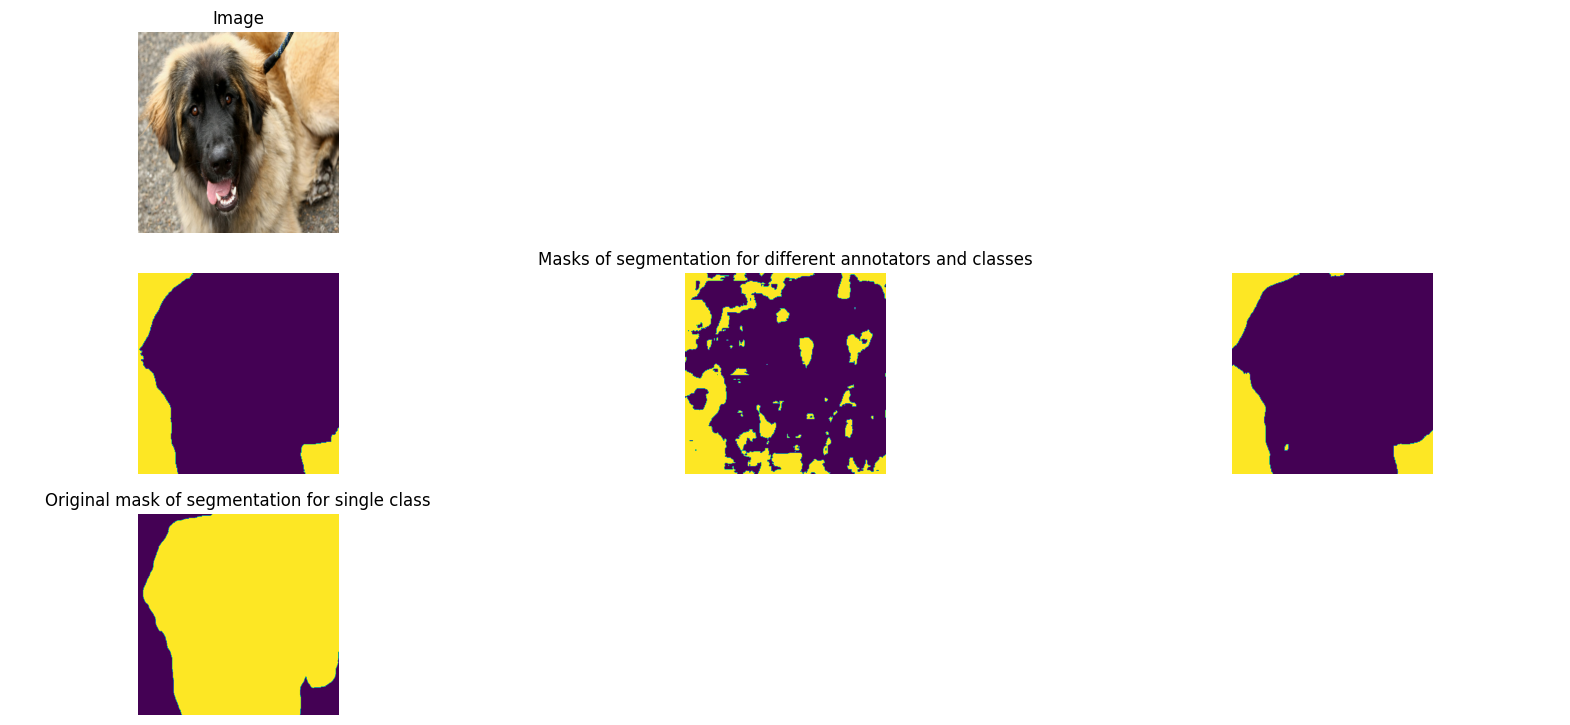

In [10]:
random_sample_visualization(train_dataset, config['Number of classes'], config['Num of annotators'], annotators=config['Annotators train'],
                            ground_truth=config['Ground truth train'],single_class=config['Single class train'])

In [11]:
import torch
import torch.nn as nn

class TGCE_SS(nn.Module):
    def __init__(self, annotators=3, classes=2, ignore_value=0.6, q=0.48029, 
                 alpha_factor=0.5, gamma=5, sigma= 0.001, lambda_factor=1.0, smooth=1e-7):
        super(TGCE_SS, self).__init__()
        self.K_ = classes
        self.R = annotators
        self.ignore_value = ignore_value
        self.q = q
        self.smooth = smooth
        self.lambda_factor = lambda_factor
        self.alpha_factor = alpha_factor
        self.sigma = sigma
        self.gamma = gamma
    
    def forward(self, y_pred, annotations):
        
        # Obtener el dispositivo de los tensores de entrada
        device = y_pred.device
 
        annotations_ = annotations.clone()
        lambdas_ = y_pred[:, self.K_:, :, :]

        ##################################################### TGCE Section #########################################################################
        
        # Reshape annotations para separar clases y anotadores
        shape_annotations = annotations.shape
        annotations = annotations.reshape(
            shape_annotations[0], self.K_, self.R, 
            shape_annotations[2], shape_annotations[3]
        ).contiguous()
        
        # Crear máscara para valores a ignorar
        valid_mask = torch.all(annotations != self.ignore_value, dim=1)
        valid_mask = valid_mask.float()
        
        # Establecer valores ignorados a 0
        annotations = torch.where(
            annotations != self.ignore_value,
            annotations,
            torch.zeros_like(annotations)
        )
        
        # Extraer puntuaciones de fiabilidad y predicciones
        Lambda_r = y_pred[:,self.K_:,:,:]
        y_pred_ = y_pred[:,:self.K_,:,:].contiguous()
        
        # Dimensiones del batch y espaciales
        N, W, H = y_pred_.shape[0], y_pred_.shape[2], y_pred_.shape[3]
        
        # Pequeña constante para estabilidad numérica
        epsilon = 1e-8
        
        # Recortar valores para evitar problemas numéricos
        y_pred_ = torch.clamp(y_pred_, epsilon, 1.0 - epsilon)
        
        # Expandir predicciones para coincidir con dimensión de anotadores
        # Reorganizar para que coincida con la forma [N, K, R, W, H]
        y_pred_ = y_pred_.unsqueeze(2).repeat(1, 1, self.R, 1, 1)
        
        # Calcular términos de la función de pérdida
        term_r = torch.mean(
            torch.mul(
                annotations,
                (torch.ones((N, self.K_, self.R, W, H), device=device) - 
                 torch.pow(y_pred_, self.q)) / (self.q + epsilon + self.smooth)
            ),
            dim=1
        )
        
        term_c = torch.mul(
            torch.ones((N, self.R, W, H), device=device) - Lambda_r,
            (torch.ones((N, self.R, W, H), device=device) - 
             torch.pow((1 / self.K_ + self.smooth) * 
                      torch.ones((N, self.R, W, H), device=device), self.q)
            ) / (self.q + epsilon + self.smooth)
        )
        
        # Combinar términos y aplicar máscara
        combined_terms = torch.mul(Lambda_r, term_r) + term_c
        masked_terms = torch.mul(combined_terms, valid_mask)
        
        # Calcular pérdida media solo sobre píxeles válidos
        valid_pixel_count = torch.maximum(
            torch.sum(valid_mask), 
            torch.tensor(1.0, device=device)
        )
        
        TGCE = torch.sum(masked_terms) / valid_pixel_count

        ##################################################### RBFKA Section #########################################################################
 
        ######### Annotations Kernel ##########

        N, _, H, W = annotations_.shape
        annotations_ = annotations_.reshape(N, self.K_, self.R, H, W)
        annotations_ = annotations_.permute(0, 2, 3, 4, 1).contiguous()
        
        annotations_i = annotations_.repeat_interleave(self.R, dim=1)
        annotations_j = annotations_.repeat(1, self.R, 1, 1, 1)
        
        mask_i = (annotations_i != self.ignore_value)
        valid_images_i = torch.any(mask_i, dim=(2, 3, 4))
        mask_i = mask_i.float()
        
        mask_j = (annotations_j != self.ignore_value)
        valid_images_j = torch.any(mask_j, dim=(2, 3, 4))
        mask_j = mask_j.float()
        
        valid_count = valid_images_i.float() * valid_images_j.float()
        
        intersection = torch.sum(annotations_i * mask_i * annotations_j * mask_j, dim=(2, 3, 4))
        sum_annotations_i = torch.sum(annotations_i * mask_i, dim=(2, 3, 4))
        sum_annotations_j = torch.sum(annotations_j * mask_j, dim=(2, 3, 4))
        union_dice = sum_annotations_i + sum_annotations_j
        
        dice = ((2. * intersection) / (union_dice + self.smooth)) / (valid_count + self.smooth)
        kernel_annotations = torch.mean(dice.reshape(N, self.R, self.R), dim=0)

        ######### Lambdas Kernel ##########

        N = lambdas_.shape[0]

        # Preparar lambdas_i y lambdas_j para el cálculo del kernel gaussiano
        lambdas_i = lambdas_.repeat_interleave(self.R, dim=1)
        lambdas_j = lambdas_.repeat(1, self.R, 1, 1)
        
        # Calcular el kernel gaussiano
        gaussian_k = torch.mean(torch.exp(-torch.square(lambdas_i - lambdas_j) / (2.0 * self.sigma * self.sigma)), dim=(2, 3))
        
        # Reformar y calcular la media
        kernel_lambdas = torch.mean(gaussian_k.reshape(N, self.R, self.R), dim=0)

        ######### RBFKA calculation ##########

        # Reshaping de los kernels
        kernel_lambdas_reshaped = kernel_lambdas.reshape(1, -1)
        kernel_annotations_reshaped = kernel_annotations.reshape(1, -1)
        
        # Cálculo de las normas
        kernel_lambdas_reshaped_norm = torch.sum(torch.square(kernel_lambdas_reshaped), dim=1, keepdim=True)
        kernel_annotations_reshaped_norm = torch.sum(torch.square(kernel_annotations_reshaped), dim=1, keepdim=True)
        
        # Cálculo de las distancias
        dists = kernel_lambdas_reshaped_norm - 2 * torch.matmul(kernel_lambdas_reshaped, kernel_annotations_reshaped.t()) + kernel_annotations_reshaped_norm.t()
        
        # Aplicar RBF 
        RBF = torch.exp(-self.gamma * dists)
        RBF = RBF[0][0]

        ##################################################### Merge sections #########################################################################

        TGCE_SS = (1.0 - self.alpha_factor) * TGCE - self.alpha_factor * RBF
        
        return TGCE_SS, TGCE, RBF, kernel_annotations, kernel_lambdas

In [12]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models


class DefaultConv2D(nn.Conv2d):
    """Capa de convolución 2D con activación ReLU y padding 'same'"""
    def __init__(self, in_channels, out_channels, kernel_size=3, activation=True, **kwargs):
        super(DefaultConv2D, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size, 
            padding='same',  # Padding 'same' en PyTorch
            padding_mode='zeros',
            **kwargs
        )
        self.activation = activation
        self.relu = nn.ReLU(inplace=True) if activation else None
    
    def forward(self, x):
        x = super(DefaultConv2D, self).forward(x)
        if self.activation:
            x = self.relu(x)
        return x

class FinalConv2D(nn.Conv2d):
    """Capa de convolución 2D con activación personalizada y padding 'same'"""
    def __init__(self, in_channels, out_channels, kernel_size=3, activation=None, **kwargs):
        super(FinalConv2D, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size, 
            padding='same',  # Padding 'same' en PyTorch
            padding_mode='zeros',
            **kwargs
        )
        
        self.custom_activation = activation
    
    def forward(self, x):
        x = super(FinalConv2D, self).forward(x)
        if self.custom_activation is not None:
            x = self.custom_activation(x)
        return x

class DilatedConv(nn.Conv2d):
    """Capa de convolución 2D dilatada con activación personalizada y padding calculado"""
    def __init__(self, in_channels, out_channels, kernel_size=3, activation=None, dilation=10, **kwargs):
        super(DilatedConv, self).__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size, 
            padding=kernel_size//2 * dilation,  # Para mantener la misma resolución espacial
            dilation=dilation,
            **kwargs
        )
        self.custom_activation = activation
    
    def forward(self, x):
        x = super(DilatedConv, self).forward(x)
        if self.custom_activation is not None:
            x = self.custom_activation(x)
        return x

def kernel_initializer(seed):
    """Inicializador GlorotUniform con semilla definida"""
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
            torch.manual_seed(seed)
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                torch.manual_seed(seed)
                nn.init.zeros_(m.bias)
    return init_weights

def sparse_softmax(x):
    """Implementación de sparse_softmax en PyTorch"""
    max_x = torch.max(x, dim=1, keepdim=True)[0]
    e_x = torch.exp(x - max_x)
    sum_e_x = torch.sum(e_x, dim=1, keepdim=True)
    output = e_x / (sum_e_x + 1e-7)  # epsilon para evitar división por cero
    return output

def alpha_activation(x, alpha=0.5):
    """Implementación de alpha_activation en PyTorch"""
    # Softmax (probabilidades que suman 1)
    softmax_out = F.softmax(x, dim=1)
    
    # Sigmoid (valores independientes entre 0 y 1)
    sigmoid_out = torch.sigmoid(x)
    
    # Combina ambos usando alpha
    return (1 - alpha) * softmax_out + alpha * sigmoid_out

def residual_block(in_channels, out_channels, kernel_init_seed, block_name=""):
    """Bloque residual con normalización por lotes y activación ReLU"""
    class ResidualBlock(nn.Module):
        def __init__(self):
            super(ResidualBlock, self).__init__()
            
            self.conv1 = DefaultConv2D(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=3,
                activation=True
            )
            self.bn1 = nn.BatchNorm2d(out_channels)
            
            self.conv2 = DefaultConv2D(
                in_channels=out_channels,
                out_channels=out_channels,
                kernel_size=3,
                activation=False
            )
            self.bn2 = nn.BatchNorm2d(out_channels)
            
            # Capa de proyección si las dimensiones no coinciden
            self.shortcut = nn.Identity()
            if in_channels != out_channels:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
            
            self.relu = nn.ReLU(inplace=True)
            
            # Aplicar inicialización de kernel
            self.apply(kernel_initializer(kernel_init_seed))
            
        def forward(self, x):
            shortcut = self.shortcut(x)
            
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.conv2(x)
            x = self.bn2(x)
            
            x = x + shortcut
            x = self.relu(x)
            
            return x
    
    return ResidualBlock()

class Annot_Harmony_Model(nn.Module):
    def __init__(self, out_channels=1, n_annotators=1, activation_seg='sparse_softmax', activation_rea='sigmoid'):
        super(Annot_Harmony_Model, self).__init__()

        # Encoder (ResNet34 Backbone)
        resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        for name, param in resnet34.named_parameters():
            if 'bn' not in name:
                param.requires_grad = False

        self.first_conv = resnet34.conv1
        self.first_bn = resnet34.bn1
        self.first_relu = resnet34.relu
        self.first_maxpool = resnet34.maxpool
        self.layer1 = resnet34.layer1
        self.layer2 = resnet34.layer2
        self.layer3 = resnet34.layer3
        self.layer4 = resnet34.layer4

        # Decoder - bloques de upsampling
        self.up60 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv60 = DefaultConv2D(in_channels=512 + 256, out_channels=256)
        self.res_block60 = residual_block(256, 256, 47, "60")

        self.up70 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv70 = DefaultConv2D(in_channels=256 + 128, out_channels=128)
        self.res_block70 = residual_block(128, 128, 96, "70")

        self.up80 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv80 = DefaultConv2D(in_channels=128 + 64, out_channels=64)
        self.res_block80 = residual_block(64, 64, 98, "80")

        self.up90 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv90 = DefaultConv2D(in_channels=64 + 64, out_channels=32)
        self.res_block90 = residual_block(32, 32, 7, "90")

        self.up100 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv100 = DefaultConv2D(in_channels=32 + 3, out_channels=16)
        self.res_block100 = residual_block(16, 16, 7, "100")

        if activation_seg == 'sparse_softmax':
            self.final_conv = FinalConv2D(in_channels=16, out_channels=out_channels, kernel_size=1, activation=sparse_softmax)
        elif activation_seg == 'alpha_activation':
            self.final_conv = FinalConv2D(in_channels=16, out_channels=out_channels, kernel_size=1, activation=lambda x: alpha_activation(x, 0.5))
        else:
            activation_seg = {
                'relu': nn.ReLU(),
                'sigmoid': nn.Sigmoid(),
                'tanh': nn.Tanh()
            }.get(activation_seg, None)
            self.final_conv = FinalConv2D(in_channels=16, out_channels=out_channels, kernel_size=1, activation=activation_seg)

        if activation_rea == 'sparse_softmax':
            self.dilated_conv = DilatedConv(in_channels=16, out_channels=n_annotators, activation=sparse_softmax)
        elif activation_rea == 'alpha_activation':
            self.dilated_conv = DilatedConv(in_channels=16, out_channels=n_annotators, activation=lambda x: alpha_activation(x, 0.5))
        else:
            activation_rea = {
                'relu': nn.ReLU(),
                'sigmoid': nn.Sigmoid(),
                'tanh': nn.Tanh()
            }.get(activation_rea, None)
            self.dilated_conv = DilatedConv(in_channels=16, out_channels=n_annotators, activation=activation_rea)

        # Inicialización
        self.conv60.apply(kernel_initializer(91))
        self.conv70.apply(kernel_initializer(21))
        self.conv80.apply(kernel_initializer(96))
        self.conv90.apply(kernel_initializer(35))
        self.conv100.apply(kernel_initializer(45))
        self.final_conv.apply(kernel_initializer(42))
        self.dilated_conv.apply(kernel_initializer(42))

    def forward(self, x):
        original_input = x

        # Encoder
        x = self.first_conv(x)
        x = self.first_bn(x)
        level_1 = self.first_relu(x)

        x = self.first_maxpool(level_1)
        level_2 = self.layer1(x)
        level_3 = self.layer2(level_2)
        level_4 = self.layer3(level_3)
        bottleneck = self.layer4(level_4)

        # Decoder
        x = self.up60(bottleneck)
        x = torch.cat([level_4, x], dim=1)
        x = self.conv60(x)
        x = self.res_block60(x)

        x = self.up70(x)
        x = torch.cat([level_3, x], dim=1)
        x = self.conv70(x)
        x = self.res_block70(x)

        x = self.up80(x)
        x = torch.cat([level_2, x], dim=1)
        x = self.conv80(x)
        x = self.res_block80(x)

        x = self.up90(x)
        x = torch.cat([level_1, x], dim=1)
        x = self.conv90(x)
        x = self.res_block90(x)

        x = self.up100(x)
        x = torch.cat([original_input, x], dim=1)
        x = self.conv100(x)
        x = self.res_block100(x)

        # Salidas
        xy = self.final_conv(x)
        x_lambda = self.dilated_conv(x)
        y = torch.cat([xy, x_lambda], dim=1)
        return y

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
from torch.amp import autocast, GradScaler
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

import optuna
from optuna.visualization import (plot_optimization_history,plot_param_importances,
                                  plot_parallel_coordinate,plot_contour)

import os
import gc
import time
import random
import subprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

class Annot_Harmony_Optimization:
    
    def __init__(self,train_loader,valid_loader,config):
        
        self.epochs = config['Epochs']
        self.n_trials = config['Num trials']
        self.annotators_valid = config['Annotators valid']
        self.train_ground_truth = config['Ground truth train']
        self.valid_ground_truth = config['Ground truth valid']
        self.single_class_train = config['Single class train']
        self.single_class_valid = config['Single class valid']
        self.config = config
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.amp_ = config['AMixPre']
        self.device = torch.device('cuda:0')

    def _create_visualizations(self, study):
        """
        Crea y guarda visualizaciones de los resultados del estudio.
        
        Args:
            study: Objeto de estudio de Optuna
        """
        # Crear directorio para visualizaciones
        vis_dir = './results/visualizations'
        os.makedirs(vis_dir, exist_ok=True)
        
        # 1. Historia de optimización
        fig = plot_optimization_history(study)
        fig.write_image(os.path.join(vis_dir, "optimization_history.png"))
        
        # 2. Importancia de parámetros
        fig = plot_param_importances(study)
        fig.write_image(os.path.join(vis_dir, "param_importances.png"))
        
        # 3. Coordenadas paralelas
        fig = plot_parallel_coordinate(study)
        fig.write_image(os.path.join(vis_dir, "parallel_coordinate.png"))
        
        # 4. Crear mapas de calor para pares de hiperparámetros
        param_pairs = [
            ("q", "alpha_factor"),
            ("q", "sigma"),
            ("alpha_factor", "sigma")
        ]
        
        for p1, p2 in param_pairs:
            fig = plot_contour(study, params=[p1, p2])
            fig.write_image(os.path.join(vis_dir, f"contour_{p1}_{p2}.png"))
        
        print(f"Visualizaciones guardadas en {vis_dir}")

    def visualizations(self, images, masks, kernel_annotations_train, kernel_lambdas_train):

        self.model.eval()
        # Seleccionar una muestra aleatoria
        sample_n = random.randint(0, images.shape[0]-1)
        sample = images[sample_n:sample_n+1].to('cuda:0')
        mask_sample = masks[sample_n:sample_n+1]
        
        with torch.no_grad():
            # Usar autocast para predicción si AMP está habilitado
            if self.amp_:
                with autocast('cuda:0'):
                    prediction = self.model(sample)
            else:
                prediction = self.model(sample)
        
        # Convertir tensores a CPU y a numpy para visualización
        prediction_np = prediction.cpu().numpy()
        mask_sample_np = mask_sample.cpu().numpy()
        
        # Número de elementos a mostrar (máximo 9)
        elements_display = min(prediction_np.shape[1], 9)
        
        # Crear figura y ejes
        fig, axs = plt.subplots(4, elements_display, figsize=(13, 5))
        
        # Mostrar predicciones de las clases
        for element in random.sample(range(self.config['Number of classes']), int(min(elements_display,self.config['Number of classes']))):
            axs[0, element].imshow(prediction_np[0, element], vmin=0.0, vmax=1.0)
            axs[0, element].set_title(f'Pred class {element}')
        
        # Mostrar mapas de confiabilidad de los anotadores
        for element in random.sample(range(self.config['Num of annotators']), int(min(elements_display,self.config['Num of annotators']))):
            idx = element + self.config['Number of classes']
            axs[1, element].imshow(prediction_np[0, idx], vmin=0.0, vmax=1.0)
            axs[1, element].set_title(f"Ann {element+1}'s reliability map")

        # Mostrar matrices kernel
        kernel_annotations = torch.mean(torch.stack(kernel_annotations_train), dim=0).detach().cpu().numpy()
        im = axs[2,0].imshow(kernel_annotations, vmin=-1.0, vmax=1.0)
        plt.colorbar(im, ax=axs[2, 0])
        axs[2,0].set_title("Kernel Annotations")
        kernel_lambdas = torch.mean(torch.stack(kernel_lambdas_train), dim=0).detach().cpu().numpy()
        im_ = axs[2,1].imshow(kernel_lambdas, vmin=-1.0, vmax=1.0)
        axs[2,1].set_title("Kernel Lambdas")
        plt.colorbar(im_, ax=axs[2, 1])
        
        # Mostrar anotaciones
        for element in random.sample(range(self.config['Num of annotators']), int(min(elements_display, self.config['Num of annotators']))):
            class_ = random.sample(range(self.config['Number of classes']), 1)[0]  # Cambio aquí
            sample = element + class_ * self.config['Num of annotators']
            axs[3, element].imshow(mask_sample_np[0, sample], vmin=0.0, vmax=1.0)
            axs[3, element].set_title(f"Ann_{element+1} for class {class_}")

        [ax.axis('off') for row in axs for ax in row]
        plt.tight_layout()  
        plt.show()
        plt.close()

    def calculate_metrics(self, y_true, y_pred, ignore_value=0.6, threshold=0.5, smooth=1e-7):
        """
        Calcula métricas de segmentación con soporte para ignorar imágenes completas.

        Args:
            y_true (torch.Tensor): Tensor de ground truth
            y_pred (torch.Tensor): Tensor de predicción
            ignore_value (float): Valor en y_true que indica imágenes a ignorar
            threshold (float): Umbral para binarización
            smooth (float): Factor de suavizado

        Returns:
            Tuple of metrics: (dice, jaccard, sensitivity, specificity)
        """
        # Asegurar que sean float32
        y_true = y_true.float()
        y_pred = y_pred.float()
        
        # Convertir ignore_value a tensor para comparación
        ignore_value = torch.tensor(ignore_value, device=y_true.device)
        
        # Crear máscara para ignorar imágenes completas (donde y_true == ignore_value en todos los píxeles)
        mask = (y_true != ignore_value)  # True donde no es ignore_value
        
        # Reducir a lo largo de las dimensiones H,W
        # En PyTorch, para una imagen C,H,W, queremos reducir sobre [2,3] (H,W)
        valid_images = torch.any(mask, dim=(2, 3))  # True si la imagen tiene algún píxel válido
        mask = mask.float()
        valid_count = torch.sum(valid_images.float())  # Número de imágenes válidas
        
        # Binarizar con el threshold
        y_true = (y_true > threshold).float()
        y_pred = (y_pred > threshold).float()
        
        # Aplicar máscara para cálculos (multiplicamos por la máscara)
        intersection = torch.sum(y_true * y_pred * mask, dim=(2, 3))
        sum_true = torch.sum(y_true * mask, dim=(2, 3))
        sum_pred = torch.sum(y_pred * mask, dim=(2, 3))
        
        # Dice coefficient
        union_dice = sum_true + sum_pred
        dice = (2.0 * intersection + smooth) / (union_dice + smooth)
        dice = torch.sum(dice) / (valid_count + smooth)
        
        # Jaccard index
        union_jaccard = sum_true + sum_pred - intersection
        jaccard = (intersection + smooth) / (union_jaccard + smooth)
        jaccard = torch.sum(jaccard) / (valid_count + smooth)
        
        # Sensibilidad (recall)
        true_positives = intersection
        actual_positives = sum_true
        sensitivity = true_positives / (actual_positives + smooth)
        sensitivity = torch.sum(sensitivity) / (valid_count + smooth)
        
        # Especificidad
        true_negatives = torch.sum((1 - y_true) * (1 - y_pred) * mask, dim=(2, 3))
        actual_negatives = torch.sum((1 - y_true) * mask, dim=(2, 3))
        specificity = true_negatives / (actual_negatives + smooth)
        specificity = torch.sum(specificity) / (valid_count + smooth)
        
        # Manejar valores NaN
        dice = torch.where(torch.isnan(dice), torch.tensor(0.0, device=dice.device), dice)
        jaccard = torch.where(torch.isnan(jaccard), torch.tensor(0.0, device=jaccard.device), jaccard)
        sensitivity = torch.where(torch.isnan(sensitivity), torch.tensor(0.0, device=sensitivity.device), sensitivity)
        specificity = torch.where(torch.isnan(specificity), torch.tensor(0.0, device=specificity.device), specificity)
        
        return dice, jaccard, sensitivity, specificity

    def train_step(self, images, masks, orig_mask=None):
        """
        Ejecuta un solo paso de entrenamiento en el batch actual.

        Utiliza el mecanismo de autograd para calcular gradientes y actualizar pesos del modelo.
        Calcula métricas si ground truth está disponible.

        Args:
            images (torch.Tensor): Batch de imágenes de entrada
            masks (torch.Tensor): Batch de máscaras de anotadores
            orig_mask (torch.Tensor, optional): Batch de máscaras de ground truth

        Returns:
            Si train_ground_truth es True:
                tuple: (loss, dice, jaccard, sensitivity, specificity)
            De lo contrario:
                float: valor de pérdida
        """
        # Poner el modelo en modo de entrenamiento
        self.model.train()
        
        # Mover datos al dispositivo
        images = images.to(self.device)
        masks = masks.to(self.device)
        if orig_mask is not None:
            orig_mask = orig_mask.to(self.device)
        
        # Reiniciar gradientes
        self.optimizer.zero_grad()
        
        # Forward pass con precisión mixta si está habilitada
        if self.amp_:
            with autocast('cuda:0'):
                y_pred = self.model(images)
                loss, tgce, rbf, kernel_annotations, kernel_lambdas = self.loss_fn(y_pred, masks)
            
            # Si la pérdida no es NaN, realizar backward pass con scaling y actualizar pesos
            if not torch.isnan(loss):
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
        else:
            # Forward pass estándar
            y_pred = self.model(images)
            loss, tgce, rbf, kernel_annotations, kernel_lambdas = self.loss_fn(y_pred, masks)
            
            # Si la pérdida no es NaN, realizar backward pass y actualizar pesos
            if not torch.isnan(loss):
                loss.backward()
                self.optimizer.step()
        
        # Calcular métricas si ground truth está disponible
        if self.train_ground_truth:
            if isinstance(self.single_class_train, int):
                # Seleccionar solo la clase especificada
                selected_pred = y_pred[:, self.single_class_train:self.single_class_train+1]
                dice, jaccard, sensitivity, specificity = self.calculate_metrics(
                    orig_mask, selected_pred
                )
            else:
                # Usar todas las clases
                selected_pred = y_pred[:, :self.config['Number of classes']]
                dice, jaccard, sensitivity, specificity = self.calculate_metrics(
                    orig_mask, selected_pred
                )
            return loss.item(), tgce.item(), rbf.item(), kernel_annotations, kernel_lambdas, dice.item(), jaccard.item(), sensitivity.item(), specificity.item()
        else:
            return loss.item(), tgce.item(), rbf.item(), kernel_annotations, kernel_lambdas

    def val_step(self, images, masks=None, orig_mask=None):
        """
        Ejecuta un solo paso de validación en el batch actual.

        Calcula métricas si ground truth está disponible, sin actualizar pesos del modelo.

        Args:
            images (torch.Tensor): Batch de imágenes de entrada
            masks (torch.Tensor, optional): Batch de máscaras de anotadores
            orig_mask (torch.Tensor, optional): Batch de máscaras de ground truth

        Returns:
            Si valid_ground_truth es True:
                tuple: (loss, dice, jaccard, sensitivity, specificity)
            De lo contrario:
                float: valor de pérdida
        """
        # Poner el modelo en modo de evaluación
        self.model.eval()
        
        # Mover datos al dispositivo
        images = images.to(self.device)
        if masks is not None:
            masks = masks.to(self.device)
        if orig_mask is not None:
            orig_mask = orig_mask.to(self.device)
        
        # Desactivar el cálculo de gradientes para ahorrar memoria
        with torch.no_grad():
            # Forward pass con precisión mixta si está habilitada
            if self.amp_:
                with autocast('cuda:0'):
                    y_pred = self.model(images)
                    
                    # Si hay anotadores en validación, calcular pérdida
                    if self.annotators_valid and masks is not None:
                        loss, tgce, rbf, _, _ = self.loss_fn(y_pred, masks)
                        loss = loss.item() if not torch.isnan(loss) else 0.0
            else:
                # Forward pass estándar
                y_pred = self.model(images)
                
                # Si hay anotadores en validación, calcular pérdida
                if self.annotators_valid and masks is not None:
                    loss, tgce, rbf, _, _ = self.loss_fn(y_pred, masks)
                    loss = loss.item() if not torch.isnan(loss) else 0.0
            
            # Si hay ground truth en validación, calcular métricas
            if self.valid_ground_truth and orig_mask is not None:
                if isinstance(self.single_class_valid, int):
                    # Seleccionar solo la clase especificada
                    selected_pred = y_pred[:, self.single_class_valid:self.single_class_valid+1]
                    dice, jaccard, sensitivity, specificity = self.calculate_metrics(
                        orig_mask, selected_pred
                    )
                else:
                    # Usar todas las clases
                    selected_pred = y_pred[:, :self.config['Number of classes']]
                    dice, jaccard, sensitivity, specificity = self.calculate_metrics(
                        orig_mask, selected_pred
                    )
            
            # Retornar los valores adecuados según la configuración
            if self.annotators_valid and self.valid_ground_truth:
                return loss, tgce.item(), rbf.item(), dice.item(), jaccard.item(), sensitivity.item(), specificity.item()
            elif self.annotators_valid and not self.valid_ground_truth:
                return loss, tgce.item(), rbf.item()
            elif not self.annotators_valid and self.valid_ground_truth:
                return dice.item(), jaccard.item(), sensitivity.item(), specificity.item()
            else:
                raise ValueError("Configuración de datos de validación no válida")

    def objective(self, trial):

        params = {
            "q": trial.suggest_float("q", 0.01, 0.99),
            "alpha_factor": trial.suggest_float("alpha_factor", 0.01, 0.99),
            "sigma": trial.suggest_float("sigma", 1e-7, 0.1, log=True)  # Distribución logarítmica
        }

        print(f"Trial {trial.number}: Probando parámetros {params}")


        self.loss_fn = TGCE_SS(
                            annotators=self.config['Num of annotators'], 
                            classes=self.config['Number of classes'],
                            ignore_value=0.6, 
                            q=params["q"], 
                            alpha_factor=params["alpha_factor"], 
                            sigma=params["sigma"])

        try:
            # Ejecutar entrenamiento
            best_dice = self.trial_(trial)
            
            return best_dice
        
        except optuna.exceptions.TrialPruned:
            raise  # Re-lanzar la excepción para que Optuna la procese
        

    def trial_(self,trial):
        """
        Ejecuta el procedimiento completo de entrenamiento.

        Ejecuta los bucles de entrenamiento y validación para el número de épocas especificado.
        Implementa planificación de tasa de aprendizaje, guardado de puntos de control del modelo y registro de métricas.
        Realiza un seguimiento y guarda el mejor modelo basado en métricas de validación.
        """
        self.start_time = time.time()

        self.scaler = GradScaler() if self.amp_ else None
        if self.amp_:
            print(f"Precisión mixta automática (AMP) habilitada")

        self.model = Annot_Harmony_Model(out_channels=self.config["Number of classes"], n_annotators=self.config["Num of annotators"],
                            activation_seg='sparse_softmax', activation_rea='sigmoid')
        
        # Mover el modelo al dispositivo principal y envolver con DataParallel si hay múltiples GPUs
        self.model.to(self.device)
    
        # Inicializar el optimizador después de envolver el modelo con DataParallel
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        
        # Bucle principal de entrenamiento
        for epoch in range(self.epochs):
            print(f"\nEpoch {epoch + 1}/{self.epochs}")
            
            # Inicializar variables para seguimiento de métricas de entrenamiento
            total_train_loss = 0.0
            total_train_tgce = 0.0
            total_train_rbfka = 0.0
            num_train_batches = 0
            total_train_dice = 0.0
            total_train_jaccard = 0.0
            total_train_sensitivity = 0.0
            total_train_specificity = 0.0

            kernel_annotations_train = []
            kernel_lambdas_train = []
            
            # Bucle de entrenamiento
            for data_batch in tqdm(self.train_loader, desc=f"Training Epoch {epoch+1}/{self.epochs}"):
                if self.train_ground_truth and len(data_batch) == 3:
                    images_train, masks_train, orig_mask = data_batch
                    batch_loss,batch_tgce,batch_rbfka,batch_k_annotations,batch_k_lambdas,batch_dice,batch_jaccard,batch_sensitivity,batch_specificity = self.train_step(images_train, masks_train, orig_mask)
                    total_train_loss += batch_loss
                    total_train_tgce += batch_tgce
                    total_train_rbfka += batch_rbfka
                    kernel_annotations_train.append(batch_k_annotations)
                    kernel_lambdas_train.append(batch_k_lambdas)
                    total_train_dice += batch_dice
                    total_train_jaccard += batch_jaccard
                    total_train_sensitivity += batch_sensitivity
                    total_train_specificity += batch_specificity
                else:
                    images_train, masks_train = data_batch
                    batch_loss,batch_tgce,batch_rbfka,batch_k_annotations,batch_k_lambdas = self.train_step(images_train, masks_train)
                    total_train_loss += batch_loss
                    total_train_tgce += batch_tgce
                    total_train_rbfka += batch_rbfka
                    kernel_annotations_train.append(batch_k_annotations)
                    kernel_lambdas_train.append(batch_k_lambdas)
                
                num_train_batches += 1
            
            # Calcular métricas promedio de entrenamiento
            avg_train_loss = total_train_loss / num_train_batches
            avg_train_tgce = total_train_tgce / num_train_batches
            avg_train_rbfka = total_train_rbfka / num_train_batches
            
            if self.train_ground_truth:
                avg_train_dice = total_train_dice / num_train_batches
                avg_train_jaccard = total_train_jaccard / num_train_batches
                avg_train_sensitivity = total_train_sensitivity / num_train_batches
                avg_train_specificity = total_train_specificity / num_train_batches

            if epoch in [0,4,9,14]:
                self.visualizations(images_train, masks_train, kernel_annotations_train, kernel_lambdas_train)
            
            # Inicializar variables para seguimiento de métricas de validación
            total_val_loss = 0.0
            total_val_tgce = 0.0
            total_val_rbfka = 0.0
            num_val_batches = 0
            total_val_dice = 0.0
            total_val_jaccard = 0.0
            total_val_sensitivity = 0.0
            total_val_specificity = 0.0
            
            # Bucle de validación (si hay conjunto de validación)
            if self.valid_loader is not None:
                for data_batch in tqdm(self.valid_loader, desc=f"Validation Epoch {epoch+1}/{self.epochs}"):
                    if self.annotators_valid and self.valid_ground_truth and len(data_batch) == 3:
                        images, masks, orig_mask = data_batch
                        batch_loss,batch_tgce,batch_rbfka,batch_dice,batch_jaccard,batch_sensitivity,batch_specificity = self.val_step(images, masks, orig_mask)
                        total_val_loss += batch_loss
                        total_val_tgce += batch_tgce
                        total_val_rbfka += batch_rbfka
                        total_val_dice += batch_dice
                        total_val_jaccard += batch_jaccard
                        total_val_sensitivity += batch_sensitivity
                        total_val_specificity += batch_specificity
                    elif self.annotators_valid and not self.valid_ground_truth and len(data_batch) == 2:
                        images, masks = data_batch
                        batch_loss,batch_tgce,batch_rbfka = self.val_step(images, masks)
                        total_val_loss += batch_loss
                        total_val_tgce += batch_tgce
                        total_val_rbfka += batch_rbfka
                    elif not self.annotators_valid and self.valid_ground_truth and len(data_batch) == 2:
                        images, orig_mask = data_batch
                        batch_dice, batch_jaccard, batch_sensitivity, batch_specificity = self.val_step(images, None, orig_mask)
                        total_val_dice += batch_dice
                        total_val_jaccard += batch_jaccard
                        total_val_sensitivity += batch_sensitivity
                        total_val_specificity += batch_specificity
                    else:
                        raise ValueError("Configuración de datos de validación no válida")
                    
                    num_val_batches += 1
                
                # Calcular métricas promedio de validación
                if self.annotators_valid:
                    avg_val_loss = total_val_loss / num_val_batches
                    avg_val_tgce = total_val_tgce / num_val_batches
                    avg_val_rbfka = total_val_rbfka / num_val_batches
                if self.valid_ground_truth:
                    avg_val_dice = total_val_dice / num_val_batches
                    avg_val_jaccard = total_val_jaccard / num_val_batches
                    avg_val_sensitivity = total_val_sensitivity / num_val_batches
                    avg_val_specificity = total_val_specificity / num_val_batches
            
            # Calcular tiempo transcurrido
            elapsed_time = time.time() - self.start_time
            elapsed_minutes = int(elapsed_time // 60)
            elapsed_seconds = int(elapsed_time % 60)
            
            # Imprimir pérdida de entrenamiento y validación
            message = f"Train loss: {'zero' if avg_train_loss == 0 else f'{avg_train_loss:.5f}'} | Time: {elapsed_minutes}m {elapsed_seconds}s | TGCE: {avg_train_tgce:.5f} | RBFKA: {avg_train_rbfka:.5f}"
            
            if self.annotators_valid:
                message += f" | Val loss: {'zero' if avg_val_loss == 0 else f'{avg_val_loss:.5f}'} | TGCE: {avg_val_tgce:.5f} | RBFKA: {avg_val_rbfka:.5f}"
                    
            print(message)
            
            if self.train_ground_truth:
                train_metrics = (
                    f"Train_DICE: {'zero' if avg_train_dice == 0 else f'{avg_train_dice:.5f}'} | "
                    f"Train_Jaccard: {'zero' if avg_train_jaccard == 0 else f'{avg_train_jaccard:.5f}'} | "
                    f"Train_Sensitivity: {'zero' if avg_train_sensitivity == 0 else f'{avg_train_sensitivity:.5f}'} | "
                    f"Train_Specificity: {'zero' if avg_train_specificity == 0 else f'{avg_train_specificity:.5f}'} "
                )
                print(train_metrics)   
            
            if self.valid_ground_truth:
                val_metrics = (
                    f"Val_DICE: {'zero' if avg_val_dice == 0 else f'{avg_val_dice:.5f}'} | "
                    f"Val_Jaccard: {'zero' if avg_val_jaccard == 0 else f'{avg_val_jaccard:.5f}'} | "
                    f"Val_Sensitivity: {'zero' if avg_val_sensitivity == 0 else f'{avg_val_sensitivity:.5f}'} | "
                    f"Val_Specificity: {'zero' if avg_val_specificity == 0 else f'{avg_val_specificity:.5f}'} "
                )
                
                print(val_metrics)
                    
            trial.report(avg_val_dice, epoch)
            if trial.should_prune():
                self.visualizations(images_train, masks_train, kernel_annotations_train, kernel_lambdas_train)
                print(f"Trial {trial.number} ha sido podado en la época {epoch+1}")
                raise optuna.exceptions.TrialPruned()    
        
        # Limpiar memoria
        gc.collect()
        torch.cuda.empty_cache()
        print("\n¡Entrenamiento finalizado!")
        
        return avg_val_dice

    def start(self):
        """
        Inicia el proceso de entrenamiento.

        Crea el directorio de modelos si no existe e inicia el bucle de entrenamiento.
        """
        os.makedirs("results", exist_ok=True)
        
        
        # Crear un nuevo estudio con el optimizador
        study = optuna.create_study(
            study_name="TGCE_SS_Parameter_Optimization",
            storage="sqlite:///results/optuna_studies.db",
            direction="maximize",  # Maximizar DICE
            sampler=optuna.samplers.GPSampler(),
            load_if_exists=True)
        
        # Implementar callbacks de poda para detener trials con bajo rendimiento
        pruner = optuna.pruners.MedianPruner(
            n_startup_trials=5,  # Número de trials iniciales sin poda
            n_warmup_steps=5,    # Número de épocas iniciales sin poda
            interval_steps=1)      # Revisar cada época
        
        # Asignar pruner al estudio
        study.pruner = pruner
        
        try:
            # Ejecutar optimización
            print(f"Iniciando estudio con {self.n_trials} trials")
            study.optimize(self.objective, n_trials=self.n_trials)
            
            # Mostrar y guardar visualizaciones
            self._create_visualizations(study)
            
            # Mostrar los mejores hiperparámetros encontrados
            print("Estudio completado con éxito.")
            print(f"Mejor valor: {study.best_value}")
            print(f"Mejores hiperparámetros: {study.best_params}")
            
            return study
            
        except KeyboardInterrupt:
            print("Estudio interrumpido por el usuario.")
            return study

In [14]:
!rm -rf /kaggle/working/results

/tmp/ipykernel_665/3085741403.py:565: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  sampler=optuna.samplers.GPSampler(),
[I 2025-04-23 15:50:55,337] A new study created in RDB with name: TGCE_SS_Parameter_Optimization


Iniciando estudio con 40 trials
Trial 0: Probando parámetros {'q': 0.601449267288041, 'alpha_factor': 0.9513607417386144, 'sigma': 6.902271375514895e-06}
Precisión mixta automática (AMP) habilitada

Epoch 1/15


Training Epoch 1/15: 100%|██████████| 32/32 [00:40<00:00,  1.27s/it]


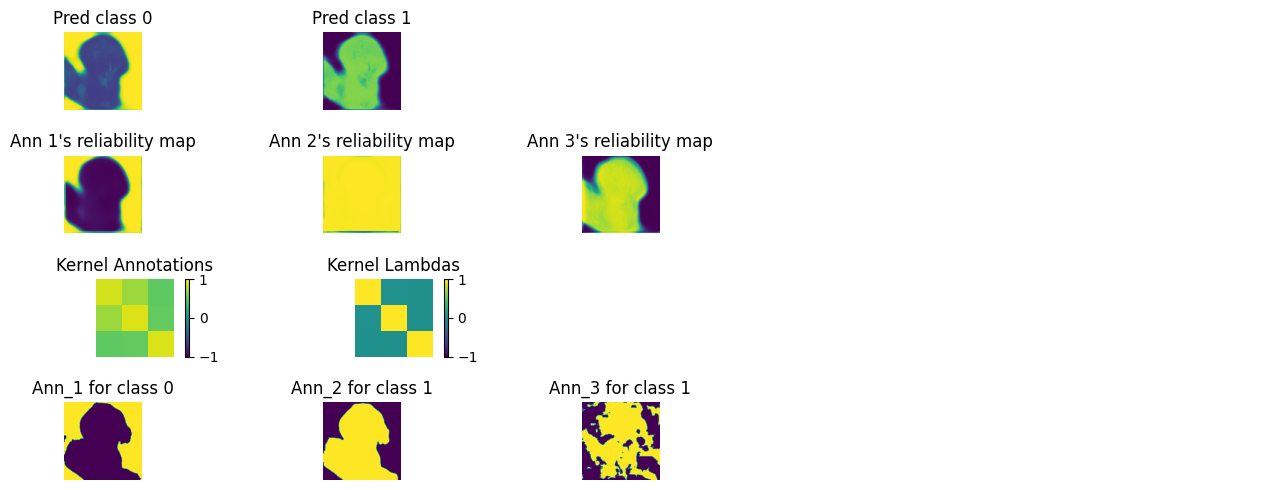

Validation Epoch 1/15: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train loss: 0.01747 | Time: 0m 48s | TGCE: 0.36114 | RBFKA: 0.00010 | Val loss: 0.01364 | TGCE: 0.28130 | RBFKA: 0.00005
Train_DICE: 0.25107 | Train_Jaccard: 0.20685 | Train_Sensitivity: 0.22858 | Train_Specificity: 0.98077 
Val_DICE: 0.84003 | Val_Jaccard: 0.73499 | Val_Sensitivity: 0.80677 | Val_Specificity: 0.93984 

Epoch 2/15


Validation Epoch 2/15: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train loss: -0.00261 | Time: 1m 34s | TGCE: 0.19121 | RBFKA: 0.01252 | Val loss: -0.00027 | TGCE: 0.24650 | RBFKA: 0.01289
Train_DICE: 0.82423 | Train_Jaccard: 0.72280 | Train_Sensitivity: 0.80370 | Train_Specificity: 0.93297 
Val_DICE: 0.54608 | Val_Jaccard: 0.43524 | Val_Sensitivity: 0.45089 | Val_Specificity: 0.98032 

Epoch 3/15


Validation Epoch 3/15: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train loss: -0.40560 | Time: 2m 20s | TGCE: 0.42338 | RBFKA: 0.44798 | Val loss: -0.63969 | TGCE: 0.48815 | RBFKA: 0.69735
Train_DICE: 0.12214 | Train_Jaccard: 0.09792 | Train_Sensitivity: 0.10430 | Train_Specificity: 0.99160 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: 0.00000 | Val_Specificity: 0.99999 

Epoch 4/15


Validation Epoch 4/15: 100%|██████████| 8/8 [00:06<00:00,  1.21it/s]


Train loss: -0.63669 | Time: 3m 6s | TGCE: 0.47380 | RBFKA: 0.69346 | Val loss: -0.60563 | TGCE: 0.44513 | RBFKA: 0.65935
Train_DICE: 0.00197 | Train_Jaccard: 0.00196 | Train_Sensitivity: 0.00001 | Train_Specificity: 0.99972 
Val_DICE: 0.00393 | Val_Jaccard: 0.00392 | Val_Sensitivity: 0.00001 | Val_Specificity: 0.99943 

Epoch 5/15


Training Epoch 5/15: 100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


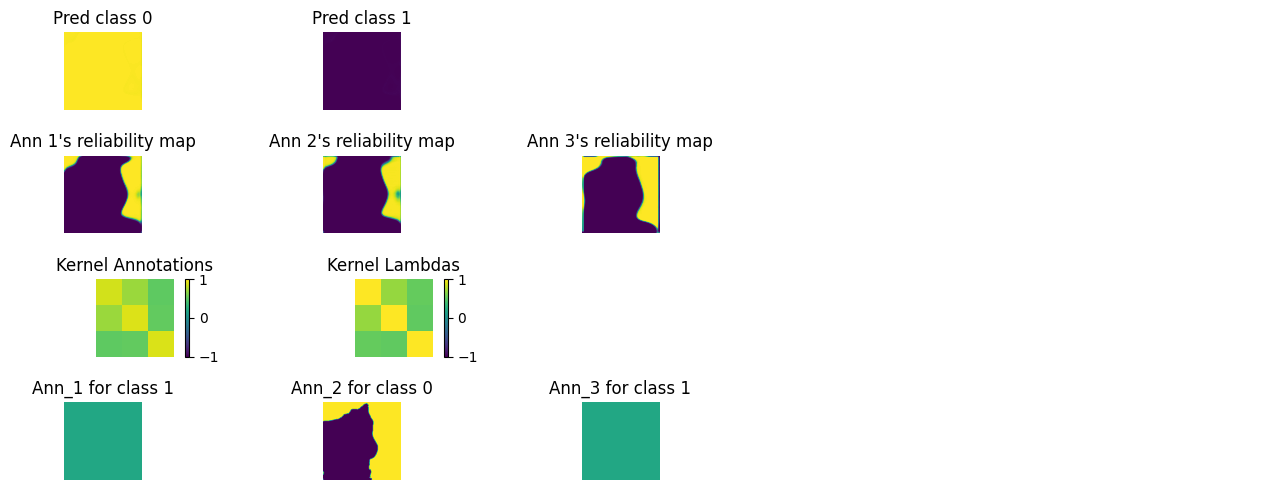

Validation Epoch 5/15: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train loss: -0.61244 | Time: 3m 52s | TGCE: 0.45848 | RBFKA: 0.66719 | Val loss: -0.63573 | TGCE: 0.47817 | RBFKA: 0.69268
Train_DICE: 0.00099 | Train_Jaccard: 0.00098 | Train_Sensitivity: 0.00001 | Train_Specificity: 0.99979 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: 0.00000 | Val_Specificity: 0.99998 

Epoch 6/15


Validation Epoch 6/15: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train loss: -0.61324 | Time: 4m 38s | TGCE: 0.45664 | RBFKA: 0.66794 | Val loss: -0.69891 | TGCE: 0.46202 | RBFKA: 0.75826
Train_DICE: 0.00098 | Train_Jaccard: 0.00098 | Train_Sensitivity: 0.00000 | Train_Specificity: 0.99999 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 7/15


Validation Epoch 7/15: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train loss: -0.64002 | Time: 5m 23s | TGCE: 0.45463 | RBFKA: 0.69599 | Val loss: -0.70746 | TGCE: 0.45473 | RBFKA: 0.76688
Train_DICE: 0.00195 | Train_Jaccard: 0.00195 | Train_Sensitivity: 0.00000 | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 8/15


Validation Epoch 8/15: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train loss: -0.64069 | Time: 6m 9s | TGCE: 0.45321 | RBFKA: 0.69662 | Val loss: -0.66199 | TGCE: 0.46851 | RBFKA: 0.71979
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 9/15


Validation Epoch 9/15: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train loss: -0.62159 | Time: 6m 54s | TGCE: 0.45105 | RBFKA: 0.67643 | Val loss: -0.69317 | TGCE: 0.44755 | RBFKA: 0.75150
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: 0.00000 | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 10/15


Training Epoch 10/15: 100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


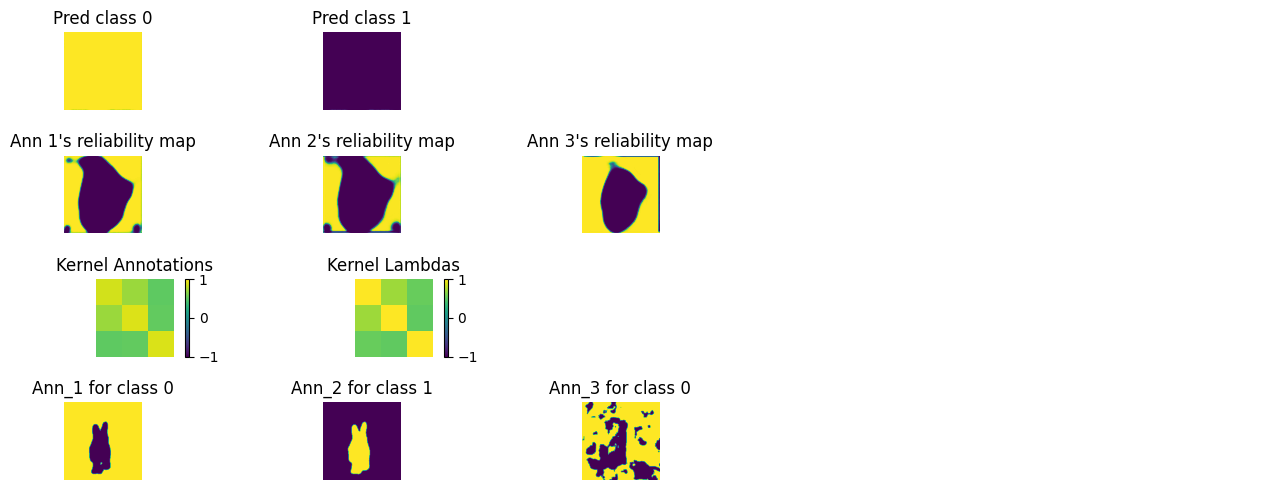

Validation Epoch 10/15: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train loss: -0.61834 | Time: 7m 41s | TGCE: 0.45278 | RBFKA: 0.67311 | Val loss: -0.67225 | TGCE: 0.43793 | RBFKA: 0.72901
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 11/15


Validation Epoch 11/15: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Train loss: -0.64256 | Time: 8m 27s | TGCE: 0.44659 | RBFKA: 0.69824 | Val loss: -0.68512 | TGCE: 0.46726 | RBFKA: 0.74404
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 12/15


Validation Epoch 12/15: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train loss: -0.63358 | Time: 9m 13s | TGCE: 0.45475 | RBFKA: 0.68922 | Val loss: -0.69989 | TGCE: 0.45162 | RBFKA: 0.75876
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 13/15


Validation Epoch 13/15: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train loss: -0.63241 | Time: 9m 59s | TGCE: 0.44900 | RBFKA: 0.68770 | Val loss: -0.70632 | TGCE: 0.45808 | RBFKA: 0.76585
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 14/15


Validation Epoch 14/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: -0.63984 | Time: 10m 46s | TGCE: 0.44651 | RBFKA: 0.69538 | Val loss: -0.67200 | TGCE: 0.43934 | RBFKA: 0.72882
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 15/15


Training Epoch 15/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


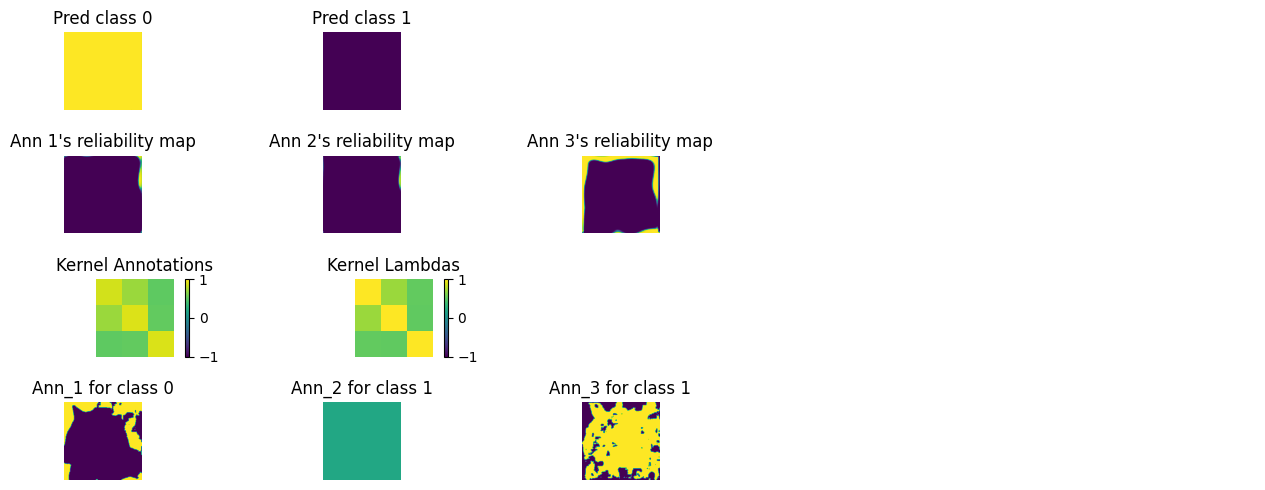

Validation Epoch 15/15: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train loss: -0.60467 | Time: 11m 32s | TGCE: 0.44611 | RBFKA: 0.65839 | Val loss: -0.69516 | TGCE: 0.44131 | RBFKA: 0.75326
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 


[I 2025-04-23 16:02:28,490] Trial 0 finished with value: 0.0039062500010280336 and parameters: {'q': 0.601449267288041, 'alpha_factor': 0.9513607417386144, 'sigma': 6.902271375514895e-06}. Best is trial 0 with value: 0.0039062500010280336.



¡Entrenamiento finalizado!
Trial 1: Probando parámetros {'q': 0.08519086187153165, 'alpha_factor': 0.862419061254406, 'sigma': 2.6580433974311776e-07}
Precisión mixta automática (AMP) habilitada

Epoch 1/15


Training Epoch 1/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


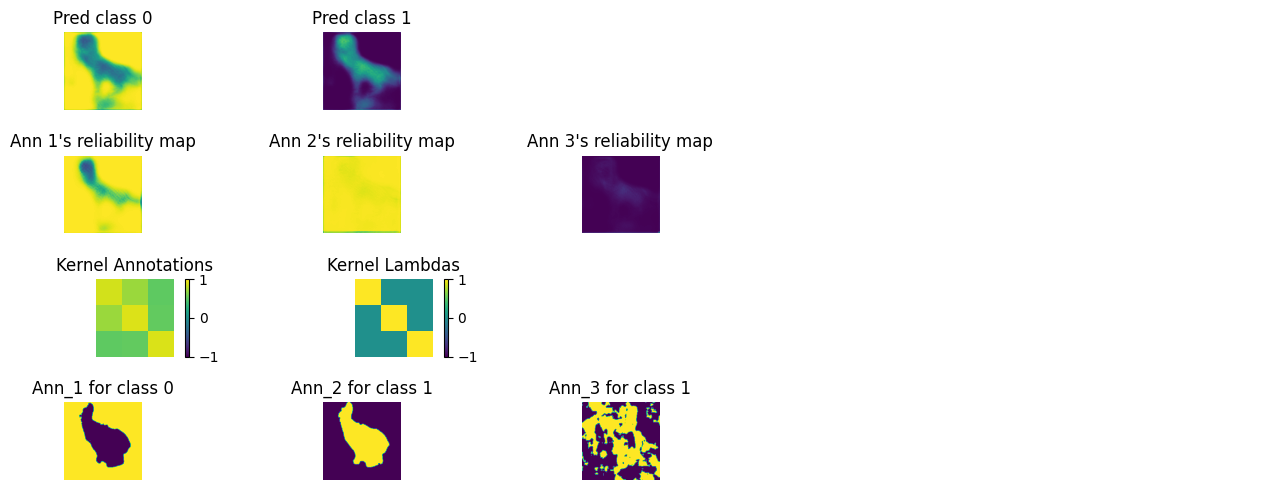

Validation Epoch 1/15: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train loss: 0.06340 | Time: 0m 46s | TGCE: 0.46145 | RBFKA: 0.00010 | Val loss: 0.05273 | TGCE: 0.38351 | RBFKA: 0.00004
Train_DICE: 0.27629 | Train_Jaccard: 0.22764 | Train_Sensitivity: 0.25259 | Train_Specificity: 0.97668 
Val_DICE: 0.71332 | Val_Jaccard: 0.57569 | Val_Sensitivity: 0.60538 | Val_Specificity: 0.96521 

Epoch 2/15


Validation Epoch 2/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: 0.03853 | Time: 1m 32s | TGCE: 0.29874 | RBFKA: 0.00298 | Val loss: 0.04126 | TGCE: 0.31536 | RBFKA: 0.00247
Train_DICE: 0.88211 | Train_Jaccard: 0.79681 | Train_Sensitivity: 0.89366 | Train_Specificity: 0.92171 
Val_DICE: 0.89355 | Val_Jaccard: 0.81617 | Val_Sensitivity: 0.87142 | Val_Specificity: 0.95416 

Epoch 3/15


Validation Epoch 3/15: 100%|██████████| 8/8 [00:06<00:00,  1.20it/s]


Train loss: 0.03598 | Time: 2m 19s | TGCE: 0.28159 | RBFKA: 0.00320 | Val loss: 0.04053 | TGCE: 0.31202 | RBFKA: 0.00278
Train_DICE: 0.90722 | Train_Jaccard: 0.83658 | Train_Sensitivity: 0.90774 | Train_Specificity: 0.94319 
Val_DICE: 0.90892 | Val_Jaccard: 0.84012 | Val_Sensitivity: 0.89795 | Val_Specificity: 0.95119 

Epoch 4/15


Validation Epoch 4/15: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train loss: 0.03449 | Time: 3m 5s | TGCE: 0.27618 | RBFKA: 0.00407 | Val loss: 0.03949 | TGCE: 0.31086 | RBFKA: 0.00381
Train_DICE: 0.91539 | Train_Jaccard: 0.85015 | Train_Sensitivity: 0.91430 | Train_Specificity: 0.94835 
Val_DICE: 0.91484 | Val_Jaccard: 0.85064 | Val_Sensitivity: 0.94071 | Val_Specificity: 0.93146 

Epoch 5/15


Training Epoch 5/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


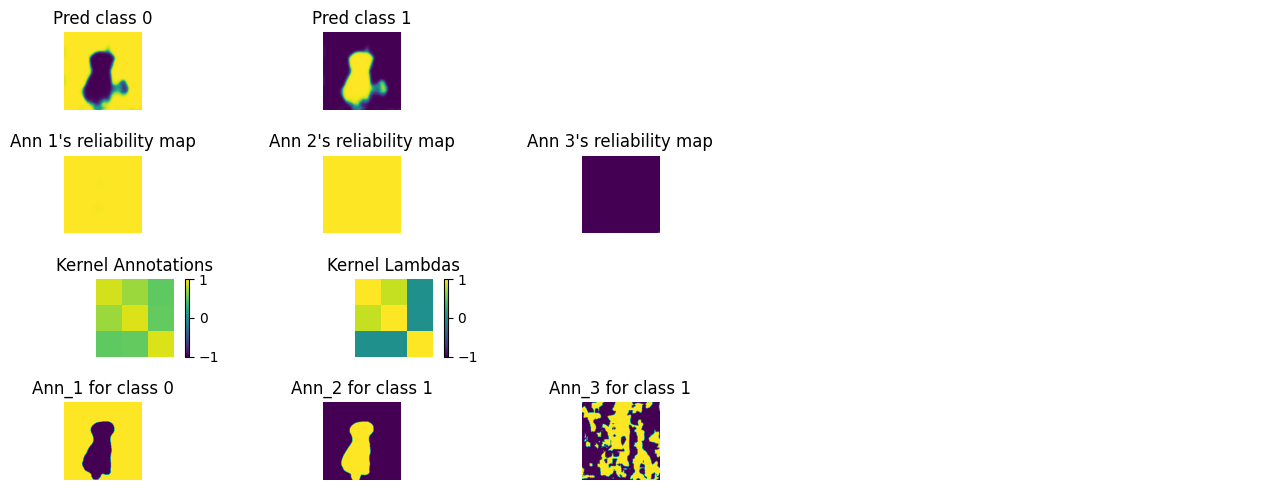

Validation Epoch 5/15: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]


Train loss: 0.03427 | Time: 3m 51s | TGCE: 0.27488 | RBFKA: 0.00412 | Val loss: 0.04084 | TGCE: 0.31544 | RBFKA: 0.00296
Train_DICE: 0.91752 | Train_Jaccard: 0.85350 | Train_Sensitivity: 0.91975 | Train_Specificity: 0.94684 
Val_DICE: 0.91354 | Val_Jaccard: 0.84755 | Val_Sensitivity: 0.88390 | Val_Specificity: 0.96932 

Epoch 6/15


Validation Epoch 6/15: 100%|██████████| 8/8 [00:05<00:00,  1.33it/s]


Train loss: 0.03387 | Time: 4m 37s | TGCE: 0.27145 | RBFKA: 0.00404 | Val loss: 0.03953 | TGCE: 0.30833 | RBFKA: 0.00336
Train_DICE: 0.92404 | Train_Jaccard: 0.86416 | Train_Sensitivity: 0.92522 | Train_Specificity: 0.95189 
Val_DICE: 0.92333 | Val_Jaccard: 0.86422 | Val_Sensitivity: 0.93057 | Val_Specificity: 0.94954 

Epoch 7/15


Validation Epoch 7/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: 0.03348 | Time: 5m 23s | TGCE: 0.26756 | RBFKA: 0.00387 | Val loss: 0.04044 | TGCE: 0.31115 | RBFKA: 0.00275
Train_DICE: 0.93025 | Train_Jaccard: 0.87420 | Train_Sensitivity: 0.93156 | Train_Specificity: 0.95395 
Val_DICE: 0.91878 | Val_Jaccard: 0.85662 | Val_Sensitivity: 0.89903 | Val_Specificity: 0.96552 

Epoch 8/15


Validation Epoch 8/15: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train loss: 0.03379 | Time: 6m 9s | TGCE: 0.26633 | RBFKA: 0.00330 | Val loss: 0.04165 | TGCE: 0.31613 | RBFKA: 0.00213
Train_DICE: 0.93078 | Train_Jaccard: 0.87521 | Train_Sensitivity: 0.93110 | Train_Specificity: 0.95598 
Val_DICE: 0.90837 | Val_Jaccard: 0.83945 | Val_Sensitivity: 0.86601 | Val_Specificity: 0.97675 

Epoch 9/15


Validation Epoch 9/15: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train loss: 0.03263 | Time: 6m 54s | TGCE: 0.26223 | RBFKA: 0.00400 | Val loss: 0.04109 | TGCE: 0.31572 | RBFKA: 0.00273
Train_DICE: 0.93676 | Train_Jaccard: 0.88536 | Train_Sensitivity: 0.93587 | Train_Specificity: 0.95981 
Val_DICE: 0.92283 | Val_Jaccard: 0.86346 | Val_Sensitivity: 0.91056 | Val_Specificity: 0.96037 

Epoch 10/15


Training Epoch 10/15: 100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


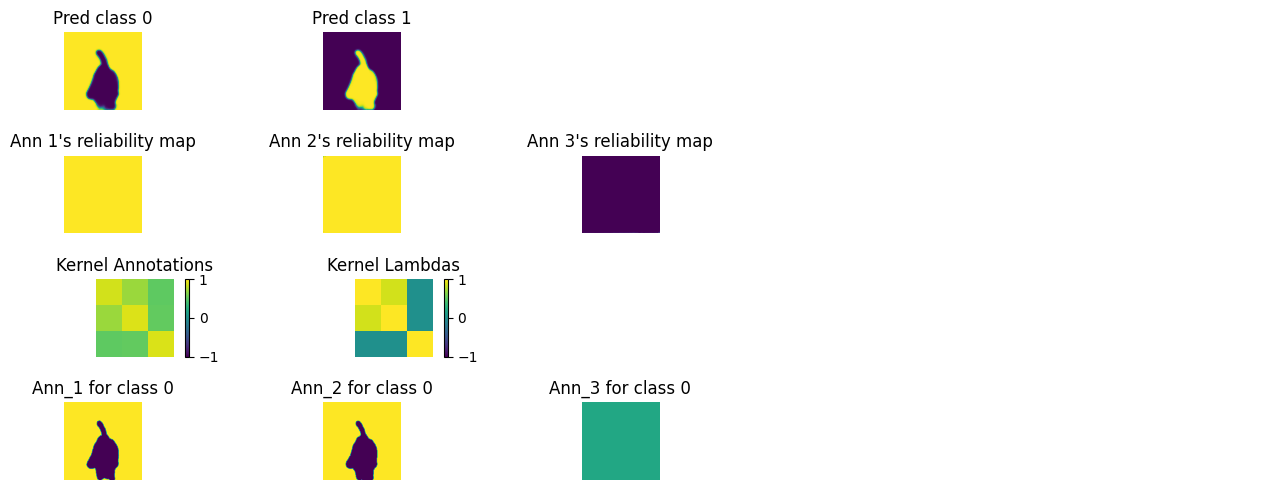

Validation Epoch 10/15: 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]


Train loss: 0.03252 | Time: 7m 41s | TGCE: 0.26222 | RBFKA: 0.00413 | Val loss: 0.04058 | TGCE: 0.31811 | RBFKA: 0.00369
Train_DICE: 0.93594 | Train_Jaccard: 0.88393 | Train_Sensitivity: 0.93567 | Train_Specificity: 0.95849 
Val_DICE: 0.92294 | Val_Jaccard: 0.86405 | Val_Sensitivity: 0.94513 | Val_Specificity: 0.94137 

Epoch 11/15


Validation Epoch 11/15: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train loss: 0.03272 | Time: 8m 27s | TGCE: 0.25985 | RBFKA: 0.00352 | Val loss: 0.04082 | TGCE: 0.32079 | RBFKA: 0.00385
Train_DICE: 0.93971 | Train_Jaccard: 0.89021 | Train_Sensitivity: 0.93823 | Train_Specificity: 0.96118 
Val_DICE: 0.91884 | Val_Jaccard: 0.85834 | Val_Sensitivity: 0.95922 | Val_Specificity: 0.91892 

Epoch 12/15


Validation Epoch 12/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: 0.03207 | Time: 9m 13s | TGCE: 0.25780 | RBFKA: 0.00394 | Val loss: 0.04190 | TGCE: 0.32001 | RBFKA: 0.00246
Train_DICE: 0.94115 | Train_Jaccard: 0.89284 | Train_Sensitivity: 0.94103 | Train_Specificity: 0.96102 
Val_DICE: 0.92369 | Val_Jaccard: 0.86497 | Val_Sensitivity: 0.90649 | Val_Specificity: 0.96721 

Epoch 13/15


Validation Epoch 13/15: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train loss: 0.03225 | Time: 9m 59s | TGCE: 0.25547 | RBFKA: 0.00335 | Val loss: 0.04227 | TGCE: 0.32267 | RBFKA: 0.00246
Train_DICE: 0.94266 | Train_Jaccard: 0.89554 | Train_Sensitivity: 0.93973 | Train_Specificity: 0.96400 
Val_DICE: 0.92519 | Val_Jaccard: 0.86679 | Val_Sensitivity: 0.90923 | Val_Specificity: 0.96654 

Epoch 14/15


Validation Epoch 14/15: 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]


Train loss: 0.03222 | Time: 10m 45s | TGCE: 0.25492 | RBFKA: 0.00330 | Val loss: 0.04216 | TGCE: 0.32025 | RBFKA: 0.00221
Train_DICE: 0.94353 | Train_Jaccard: 0.89691 | Train_Sensitivity: 0.94335 | Train_Specificity: 0.96177 
Val_DICE: 0.92030 | Val_Jaccard: 0.85859 | Val_Sensitivity: 0.90029 | Val_Specificity: 0.96267 

Epoch 15/15


Training Epoch 15/15: 100%|██████████| 32/32 [00:40<00:00,  1.26s/it]


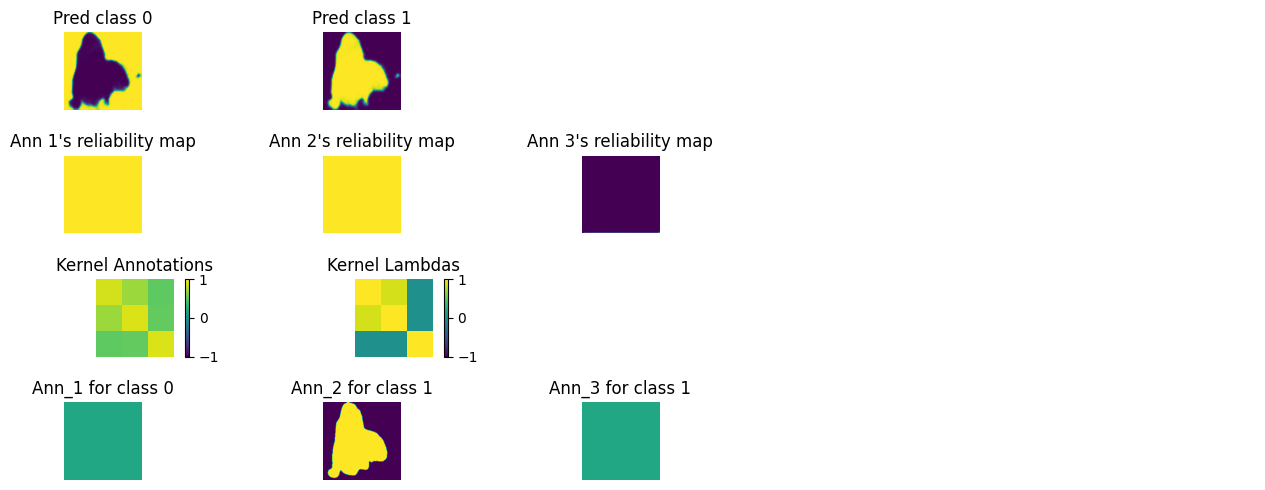

Validation Epoch 15/15: 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]


Train loss: 0.03224 | Time: 11m 32s | TGCE: 0.25437 | RBFKA: 0.00320 | Val loss: 0.04230 | TGCE: 0.32268 | RBFKA: 0.00243
Train_DICE: 0.94289 | Train_Jaccard: 0.89575 | Train_Sensitivity: 0.94120 | Train_Specificity: 0.96279 
Val_DICE: 0.92819 | Val_Jaccard: 0.87191 | Val_Sensitivity: 0.92126 | Val_Specificity: 0.95880 


[I 2025-04-23 16:14:01,307] Trial 1 finished with value: 0.9281929433345795 and parameters: {'q': 0.08519086187153165, 'alpha_factor': 0.862419061254406, 'sigma': 2.6580433974311776e-07}. Best is trial 1 with value: 0.9281929433345795.



¡Entrenamiento finalizado!
Trial 2: Probando parámetros {'q': 0.05867874210718545, 'alpha_factor': 0.2718111300203946, 'sigma': 0.0014740292024879719}
Precisión mixta automática (AMP) habilitada

Epoch 1/15


Training Epoch 1/15: 100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


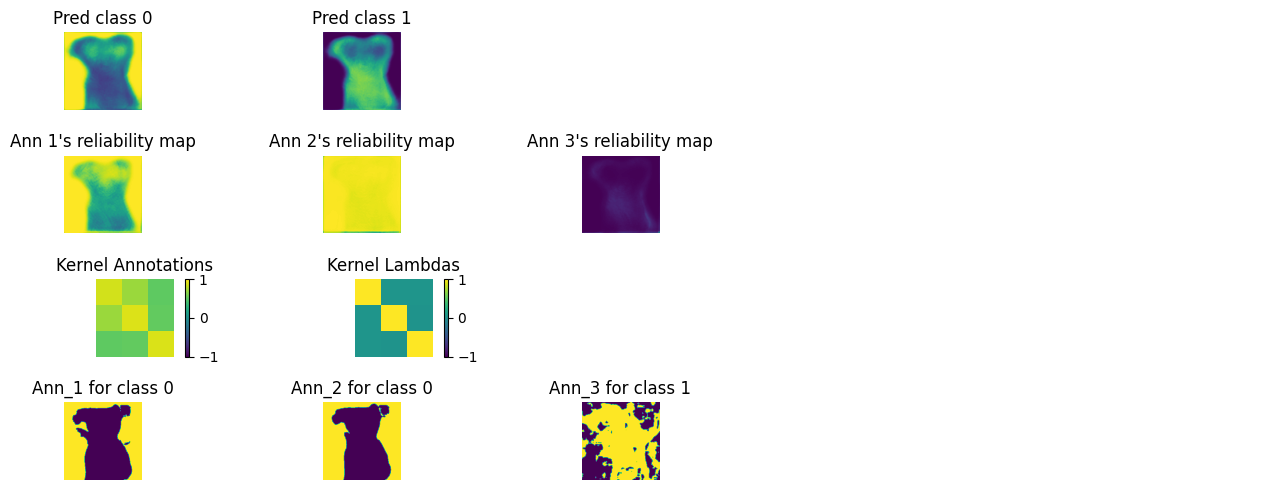

Validation Epoch 1/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: 0.34046 | Time: 0m 47s | TGCE: 0.46765 | RBFKA: 0.00026 | Val loss: 0.27954 | TGCE: 0.38391 | RBFKA: 0.00007
Train_DICE: 0.28559 | Train_Jaccard: 0.23498 | Train_Sensitivity: 0.26104 | Train_Specificity: 0.97512 
Val_DICE: 0.71622 | Val_Jaccard: 0.57901 | Val_Sensitivity: 0.61987 | Val_Specificity: 0.95035 

Epoch 2/15


Validation Epoch 2/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: 0.21795 | Time: 1m 32s | TGCE: 0.30043 | RBFKA: 0.00300 | Val loss: 0.23130 | TGCE: 0.31851 | RBFKA: 0.00234
Train_DICE: 0.88202 | Train_Jaccard: 0.79653 | Train_Sensitivity: 0.88197 | Train_Specificity: 0.93155 
Val_DICE: 0.90113 | Val_Jaccard: 0.82788 | Val_Sensitivity: 0.89831 | Val_Specificity: 0.94505 

Epoch 3/15


Validation Epoch 3/15: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train loss: 0.20617 | Time: 2m 18s | TGCE: 0.28448 | RBFKA: 0.00361 | Val loss: 0.22707 | TGCE: 0.31313 | RBFKA: 0.00348
Train_DICE: 0.90753 | Train_Jaccard: 0.83700 | Train_Sensitivity: 0.90494 | Train_Specificity: 0.94588 
Val_DICE: 0.91166 | Val_Jaccard: 0.84484 | Val_Sensitivity: 0.92386 | Val_Specificity: 0.93558 

Epoch 4/15


Validation Epoch 4/15: 100%|██████████| 8/8 [00:06<00:00,  1.22it/s]


Train loss: 0.20207 | Time: 3m 4s | TGCE: 0.27911 | RBFKA: 0.00433 | Val loss: 0.22885 | TGCE: 0.31573 | RBFKA: 0.00391
Train_DICE: 0.91492 | Train_Jaccard: 0.84918 | Train_Sensitivity: 0.90841 | Train_Specificity: 0.95257 
Val_DICE: 0.91645 | Val_Jaccard: 0.85319 | Val_Sensitivity: 0.93951 | Val_Specificity: 0.93305 

Epoch 5/15


Training Epoch 5/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


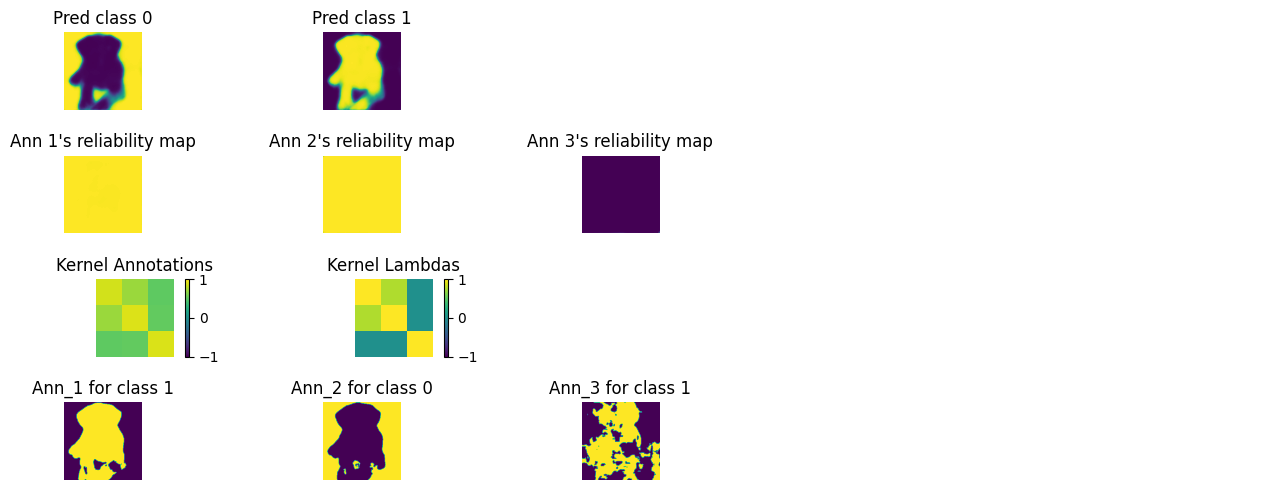

Validation Epoch 5/15: 100%|██████████| 8/8 [00:05<00:00,  1.33it/s]


Train loss: 0.20030 | Time: 3m 51s | TGCE: 0.27684 | RBFKA: 0.00474 | Val loss: 0.23104 | TGCE: 0.31847 | RBFKA: 0.00318
Train_DICE: 0.91959 | Train_Jaccard: 0.85687 | Train_Sensitivity: 0.91840 | Train_Specificity: 0.95081 
Val_DICE: 0.91054 | Val_Jaccard: 0.84242 | Val_Sensitivity: 0.87380 | Val_Specificity: 0.97381 

Epoch 6/15


Validation Epoch 6/15: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train loss: 0.19851 | Time: 4m 36s | TGCE: 0.27427 | RBFKA: 0.00447 | Val loss: 0.22950 | TGCE: 0.31663 | RBFKA: 0.00392
Train_DICE: 0.92411 | Train_Jaccard: 0.86416 | Train_Sensitivity: 0.92086 | Train_Specificity: 0.95577 
Val_DICE: 0.92193 | Val_Jaccard: 0.86213 | Val_Sensitivity: 0.94420 | Val_Specificity: 0.93563 

Epoch 7/15


Validation Epoch 7/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: 0.19517 | Time: 5m 23s | TGCE: 0.26978 | RBFKA: 0.00472 | Val loss: 0.23032 | TGCE: 0.31770 | RBFKA: 0.00378
Train_DICE: 0.93124 | Train_Jaccard: 0.87576 | Train_Sensitivity: 0.92897 | Train_Specificity: 0.95733 
Val_DICE: 0.92014 | Val_Jaccard: 0.85877 | Val_Sensitivity: 0.89932 | Val_Specificity: 0.96755 

Epoch 8/15


Validation Epoch 8/15: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train loss: 0.19390 | Time: 6m 9s | TGCE: 0.26790 | RBFKA: 0.00435 | Val loss: 0.22960 | TGCE: 0.31662 | RBFKA: 0.00354
Train_DICE: 0.93219 | Train_Jaccard: 0.87756 | Train_Sensitivity: 0.92863 | Train_Specificity: 0.95985 
Val_DICE: 0.91644 | Val_Jaccard: 0.85259 | Val_Sensitivity: 0.88796 | Val_Specificity: 0.97040 

Epoch 9/15


Validation Epoch 9/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: 0.19111 | Time: 6m 55s | TGCE: 0.26416 | RBFKA: 0.00459 | Val loss: 0.23481 | TGCE: 0.32390 | RBFKA: 0.00388
Train_DICE: 0.93715 | Train_Jaccard: 0.88600 | Train_Sensitivity: 0.93309 | Train_Specificity: 0.96260 
Val_DICE: 0.92158 | Val_Jaccard: 0.86116 | Val_Sensitivity: 0.90656 | Val_Specificity: 0.96128 

Epoch 10/15


Training Epoch 10/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


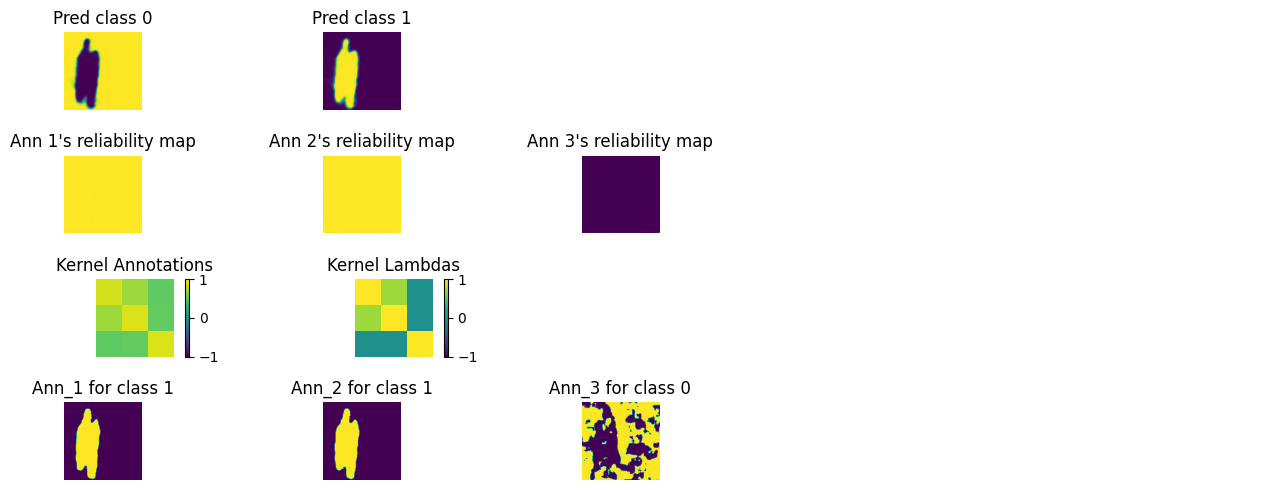

Validation Epoch 10/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: 0.19036 | Time: 7m 41s | TGCE: 0.26361 | RBFKA: 0.00589 | Val loss: 0.23645 | TGCE: 0.32620 | RBFKA: 0.00399
Train_DICE: 0.93700 | Train_Jaccard: 0.88566 | Train_Sensitivity: 0.93438 | Train_Specificity: 0.96066 
Val_DICE: 0.92257 | Val_Jaccard: 0.86347 | Val_Sensitivity: 0.93448 | Val_Specificity: 0.94871 

Epoch 11/15


Validation Epoch 11/15: 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]


Train loss: 0.18913 | Time: 8m 27s | TGCE: 0.26140 | RBFKA: 0.00447 | Val loss: 0.23595 | TGCE: 0.32555 | RBFKA: 0.00407
Train_DICE: 0.94023 | Train_Jaccard: 0.89111 | Train_Sensitivity: 0.93608 | Train_Specificity: 0.96375 
Val_DICE: 0.92391 | Val_Jaccard: 0.86591 | Val_Sensitivity: 0.94149 | Val_Specificity: 0.93982 

Epoch 12/15


Validation Epoch 12/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: 0.18751 | Time: 9m 13s | TGCE: 0.25927 | RBFKA: 0.00475 | Val loss: 0.23942 | TGCE: 0.33030 | RBFKA: 0.00404
Train_DICE: 0.94172 | Train_Jaccard: 0.89390 | Train_Sensitivity: 0.93972 | Train_Specificity: 0.96335 
Val_DICE: 0.92105 | Val_Jaccard: 0.86025 | Val_Sensitivity: 0.89682 | Val_Specificity: 0.97027 

Epoch 13/15


Validation Epoch 13/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: 0.18600 | Time: 9m 59s | TGCE: 0.25723 | RBFKA: 0.00481 | Val loss: 0.24088 | TGCE: 0.33234 | RBFKA: 0.00416
Train_DICE: 0.94326 | Train_Jaccard: 0.89651 | Train_Sensitivity: 0.93911 | Train_Specificity: 0.96540 
Val_DICE: 0.92114 | Val_Jaccard: 0.86020 | Val_Sensitivity: 0.89975 | Val_Specificity: 0.96743 

Epoch 14/15


Validation Epoch 14/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: 0.18552 | Time: 10m 46s | TGCE: 0.25663 | RBFKA: 0.00499 | Val loss: 0.23534 | TGCE: 0.32473 | RBFKA: 0.00412
Train_DICE: 0.94375 | Train_Jaccard: 0.89732 | Train_Sensitivity: 0.94203 | Train_Specificity: 0.96352 
Val_DICE: 0.92360 | Val_Jaccard: 0.86502 | Val_Sensitivity: 0.92438 | Val_Specificity: 0.95059 

Epoch 15/15


Training Epoch 15/15: 100%|██████████| 32/32 [00:40<00:00,  1.26s/it]


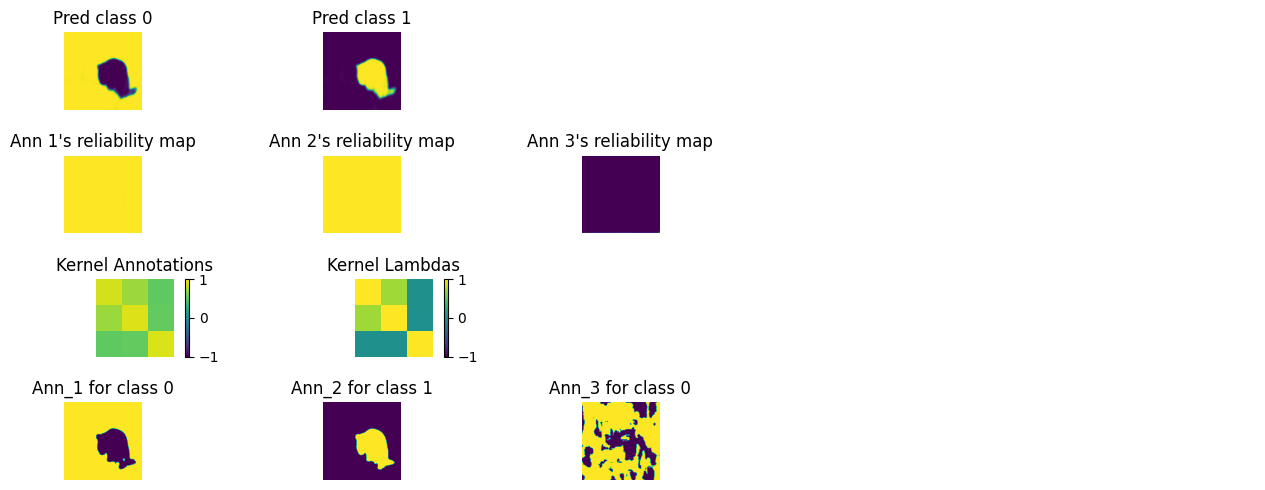

Validation Epoch 15/15: 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]


Train loss: 0.18561 | Time: 11m 33s | TGCE: 0.25661 | RBFKA: 0.00459 | Val loss: 0.24233 | TGCE: 0.33428 | RBFKA: 0.00402
Train_DICE: 0.94273 | Train_Jaccard: 0.89557 | Train_Sensitivity: 0.94025 | Train_Specificity: 0.96332 
Val_DICE: 0.92083 | Val_Jaccard: 0.85918 | Val_Sensitivity: 0.89643 | Val_Specificity: 0.96665 


[I 2025-04-23 16:25:35,003] Trial 2 finished with value: 0.9208313152194023 and parameters: {'q': 0.05867874210718545, 'alpha_factor': 0.2718111300203946, 'sigma': 0.0014740292024879719}. Best is trial 1 with value: 0.9281929433345795.



¡Entrenamiento finalizado!
Trial 3: Probando parámetros {'q': 0.9584381839251208, 'alpha_factor': 0.6813152490909441, 'sigma': 0.0001350943731186809}
Precisión mixta automática (AMP) habilitada

Epoch 1/15


Training Epoch 1/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


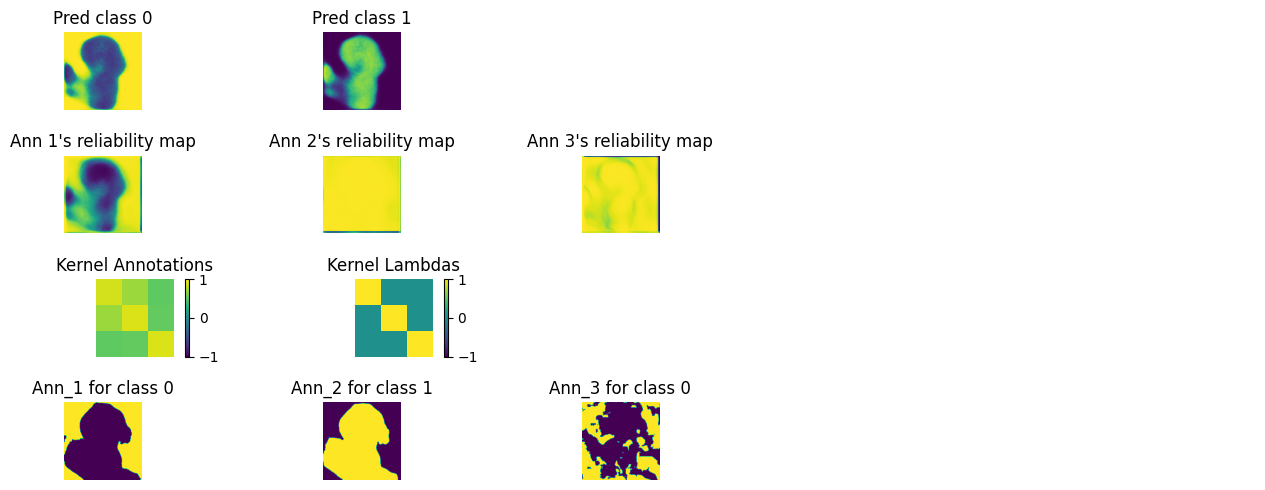

Validation Epoch 1/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: 0.09771 | Time: 0m 46s | TGCE: 0.30683 | RBFKA: 0.00010 | Val loss: 0.06106 | TGCE: 0.19171 | RBFKA: 0.00005
Train_DICE: 0.13061 | Train_Jaccard: 0.09852 | Train_Sensitivity: 0.10262 | Train_Specificity: 0.99558 
Val_DICE: 0.71144 | Val_Jaccard: 0.56799 | Val_Sensitivity: 0.58326 | Val_Specificity: 0.98608 

Epoch 2/15


Validation Epoch 2/15: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train loss: -0.17374 | Time: 1m 31s | TGCE: 0.10825 | RBFKA: 0.30564 | Val loss: -0.15551 | TGCE: 0.17153 | RBFKA: 0.30849
Train_DICE: 0.85995 | Train_Jaccard: 0.76335 | Train_Sensitivity: 0.84568 | Train_Specificity: 0.93493 
Val_DICE: 0.48370 | Val_Jaccard: 0.34671 | Val_Sensitivity: 0.34810 | Val_Specificity: 0.99654 

Epoch 3/15


Validation Epoch 3/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: -0.37618 | Time: 2m 17s | TGCE: 0.08657 | RBFKA: 0.59263 | Val loss: -0.42570 | TGCE: 0.09566 | RBFKA: 0.66956
Train_DICE: 0.88645 | Train_Jaccard: 0.80365 | Train_Sensitivity: 0.88264 | Train_Specificity: 0.93751 
Val_DICE: 0.89964 | Val_Jaccard: 0.82493 | Val_Sensitivity: 0.90598 | Val_Specificity: 0.93566 

Epoch 4/15


Validation Epoch 4/15: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train loss: -0.42089 | Time: 3m 2s | TGCE: 0.08127 | RBFKA: 0.65578 | Val loss: -0.34791 | TGCE: 0.10387 | RBFKA: 0.55922
Train_DICE: 0.90242 | Train_Jaccard: 0.82892 | Train_Sensitivity: 0.90027 | Train_Specificity: 0.94247 
Val_DICE: 0.86363 | Val_Jaccard: 0.77238 | Val_Sensitivity: 0.96995 | Val_Specificity: 0.83670 

Epoch 5/15


Training Epoch 5/15: 100%|██████████| 32/32 [00:39<00:00,  1.25s/it]


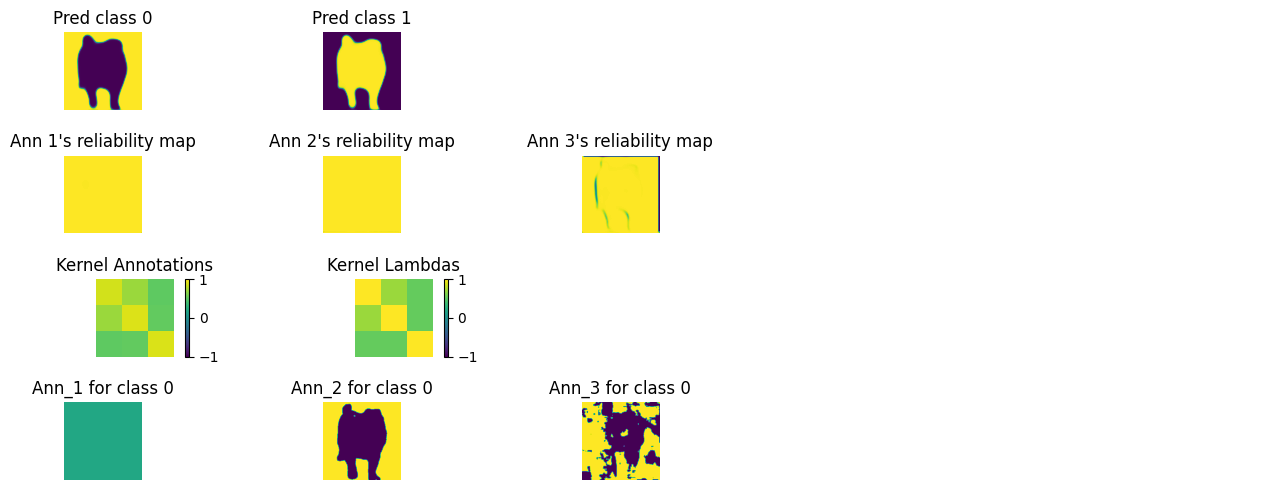

Validation Epoch 5/15: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train loss: -0.42767 | Time: 3m 49s | TGCE: 0.07948 | RBFKA: 0.66489 | Val loss: -0.44558 | TGCE: 0.09516 | RBFKA: 0.69851
Train_DICE: 0.90822 | Train_Jaccard: 0.83811 | Train_Sensitivity: 0.91556 | Train_Specificity: 0.93945 
Val_DICE: 0.90566 | Val_Jaccard: 0.83473 | Val_Sensitivity: 0.88087 | Val_Specificity: 0.96100 

Epoch 6/15


Validation Epoch 6/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: -0.43686 | Time: 4m 34s | TGCE: 0.07850 | RBFKA: 0.67792 | Val loss: -0.44250 | TGCE: 0.09377 | RBFKA: 0.69334
Train_DICE: 0.91237 | Train_Jaccard: 0.84495 | Train_Sensitivity: 0.91315 | Train_Specificity: 0.94609 
Val_DICE: 0.90532 | Val_Jaccard: 0.83497 | Val_Sensitivity: 0.94789 | Val_Specificity: 0.91435 

Epoch 7/15


Validation Epoch 7/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: -0.42904 | Time: 5m 20s | TGCE: 0.07732 | RBFKA: 0.66588 | Val loss: -0.38248 | TGCE: 0.09343 | RBFKA: 0.60509
Train_DICE: 0.91432 | Train_Jaccard: 0.84816 | Train_Sensitivity: 0.91806 | Train_Specificity: 0.94677 
Val_DICE: 0.91146 | Val_Jaccard: 0.84394 | Val_Sensitivity: 0.88372 | Val_Specificity: 0.96645 

Epoch 8/15


Validation Epoch 8/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: -0.42599 | Time: 6m 5s | TGCE: 0.07598 | RBFKA: 0.66078 | Val loss: -0.44031 | TGCE: 0.09161 | RBFKA: 0.68911
Train_DICE: 0.91968 | Train_Jaccard: 0.85649 | Train_Sensitivity: 0.91927 | Train_Specificity: 0.95039 
Val_DICE: 0.91706 | Val_Jaccard: 0.85313 | Val_Sensitivity: 0.90430 | Val_Specificity: 0.95802 

Epoch 9/15


Validation Epoch 9/15: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train loss: -0.45136 | Time: 6m 50s | TGCE: 0.07538 | RBFKA: 0.69775 | Val loss: -0.44441 | TGCE: 0.09128 | RBFKA: 0.69498
Train_DICE: 0.92150 | Train_Jaccard: 0.85981 | Train_Sensitivity: 0.92692 | Train_Specificity: 0.94722 
Val_DICE: 0.91909 | Val_Jaccard: 0.85635 | Val_Sensitivity: 0.90221 | Val_Specificity: 0.96388 

Epoch 10/15


Training Epoch 10/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


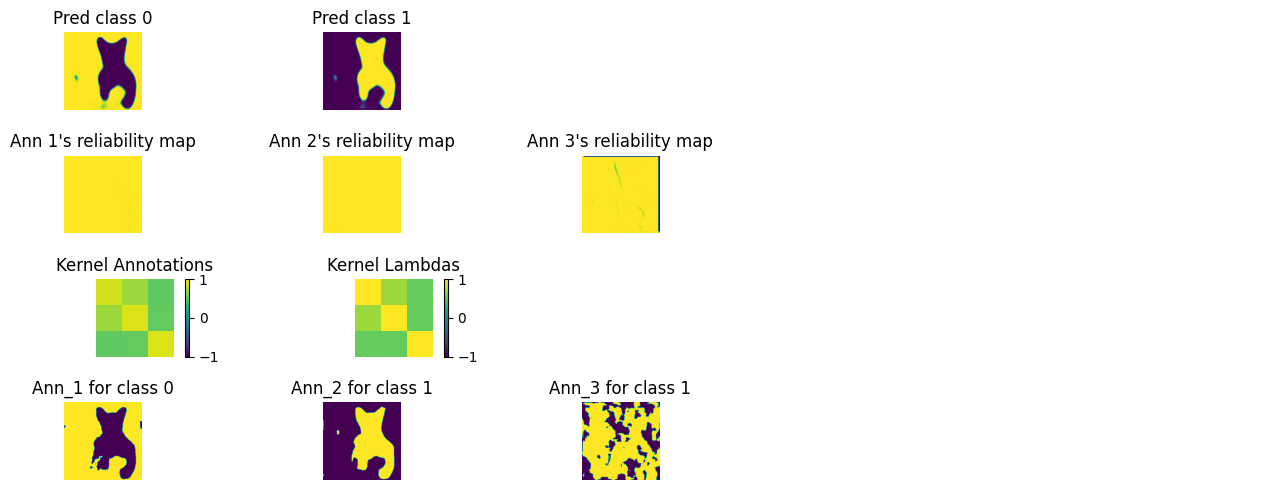

Validation Epoch 10/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: -0.42512 | Time: 7m 36s | TGCE: 0.07498 | RBFKA: 0.65904 | Val loss: -0.42807 | TGCE: 0.09374 | RBFKA: 0.67214
Train_DICE: 0.92214 | Train_Jaccard: 0.86073 | Train_Sensitivity: 0.92466 | Train_Specificity: 0.94948 
Val_DICE: 0.90715 | Val_Jaccard: 0.83678 | Val_Sensitivity: 0.86303 | Val_Specificity: 0.97717 

Epoch 11/15


Validation Epoch 11/15: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train loss: -0.42641 | Time: 8m 21s | TGCE: 0.07394 | RBFKA: 0.66045 | Val loss: -0.43971 | TGCE: 0.09542 | RBFKA: 0.69002
Train_DICE: 0.92702 | Train_Jaccard: 0.86868 | Train_Sensitivity: 0.92862 | Train_Specificity: 0.95204 
Val_DICE: 0.90424 | Val_Jaccard: 0.83229 | Val_Sensitivity: 0.85404 | Val_Specificity: 0.98096 

Epoch 12/15


Validation Epoch 12/15: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train loss: -0.44337 | Time: 9m 7s | TGCE: 0.07309 | RBFKA: 0.68495 | Val loss: -0.44537 | TGCE: 0.09185 | RBFKA: 0.69666
Train_DICE: 0.92844 | Train_Jaccard: 0.87121 | Train_Sensitivity: 0.93097 | Train_Specificity: 0.95258 
Val_DICE: 0.91989 | Val_Jaccard: 0.85767 | Val_Sensitivity: 0.89036 | Val_Specificity: 0.97290 

Epoch 13/15


Validation Epoch 13/15: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train loss: -0.42895 | Time: 9m 52s | TGCE: 0.07204 | RBFKA: 0.66329 | Val loss: -0.39614 | TGCE: 0.10148 | RBFKA: 0.62890
Train_DICE: 0.93119 | Train_Jaccard: 0.87592 | Train_Sensitivity: 0.93234 | Train_Specificity: 0.95515 
Val_DICE: 0.87422 | Val_Jaccard: 0.78617 | Val_Sensitivity: 0.79874 | Val_Specificity: 0.98717 

Epoch 14/15


Validation Epoch 14/15: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Train loss: -0.43311 | Time: 10m 38s | TGCE: 0.07214 | RBFKA: 0.66945 | Val loss: -0.46228 | TGCE: 0.09021 | RBFKA: 0.72070
Train_DICE: 0.93128 | Train_Jaccard: 0.87598 | Train_Sensitivity: 0.93334 | Train_Specificity: 0.95320 
Val_DICE: 0.92675 | Val_Jaccard: 0.86964 | Val_Sensitivity: 0.92092 | Val_Specificity: 0.95991 

Epoch 15/15


Training Epoch 15/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


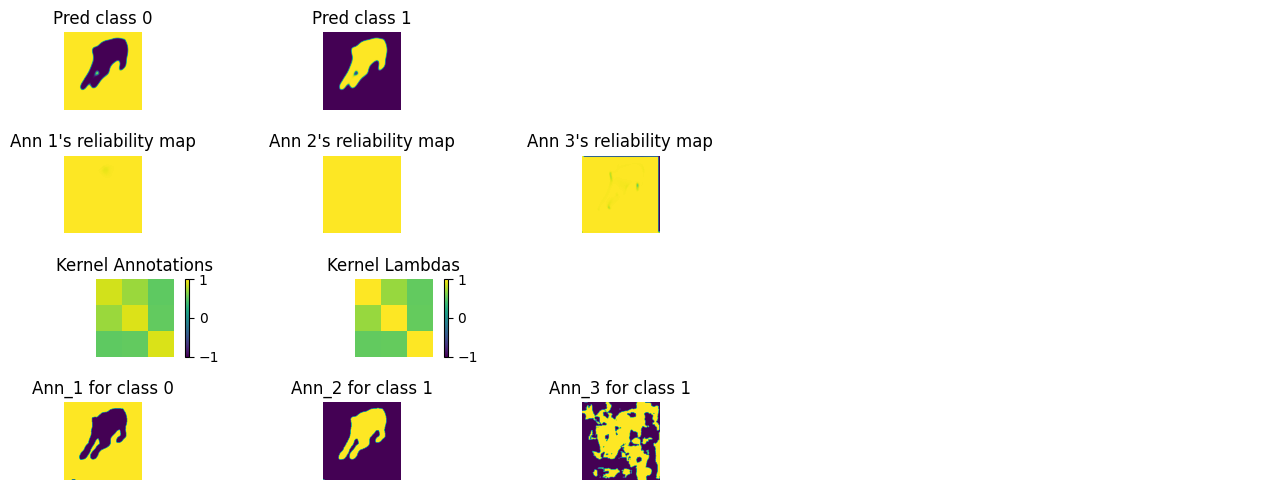

Validation Epoch 15/15: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train loss: -0.44211 | Time: 11m 24s | TGCE: 0.07187 | RBFKA: 0.68252 | Val loss: -0.46979 | TGCE: 0.08987 | RBFKA: 0.73157
Train_DICE: 0.93124 | Train_Jaccard: 0.87586 | Train_Sensitivity: 0.93403 | Train_Specificity: 0.95398 
Val_DICE: 0.92655 | Val_Jaccard: 0.86908 | Val_Sensitivity: 0.91144 | Val_Specificity: 0.96661 


[I 2025-04-23 16:37:00,310] Trial 3 finished with value: 0.9265535399317741 and parameters: {'q': 0.9584381839251208, 'alpha_factor': 0.6813152490909441, 'sigma': 0.0001350943731186809}. Best is trial 1 with value: 0.9281929433345795.



¡Entrenamiento finalizado!
Trial 4: Probando parámetros {'q': 0.9753355514409305, 'alpha_factor': 0.926482256973997, 'sigma': 3.394615915091637e-07}
Precisión mixta automática (AMP) habilitada

Epoch 1/15


Training Epoch 1/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


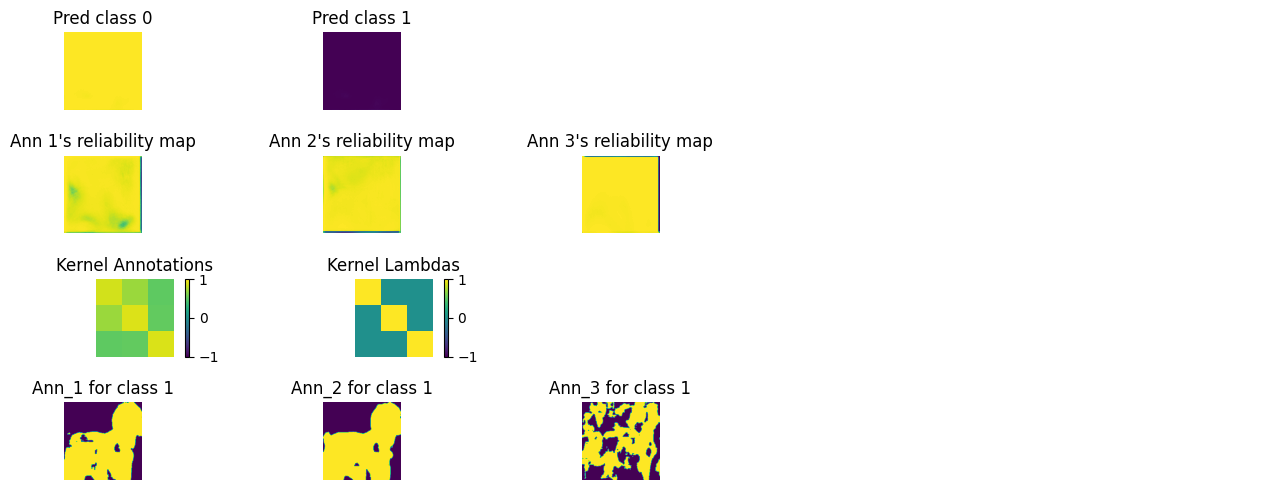

Validation Epoch 1/15: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Train loss: 0.02278 | Time: 0m 46s | TGCE: 0.31103 | RBFKA: 0.00010 | Val loss: 0.01726 | TGCE: 0.23546 | RBFKA: 0.00005
Train_DICE: 0.00339 | Train_Jaccard: 0.00316 | Train_Sensitivity: 0.00023 | Train_Specificity: 0.99992 
Val_DICE: 0.00437 | Val_Jaccard: 0.00414 | Val_Sensitivity: 0.00023 | Val_Specificity: 1.00000 

Epoch 2/15


Validation Epoch 2/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: -0.08151 | Time: 1m 32s | TGCE: 0.13421 | RBFKA: 0.09863 | Val loss: -0.12289 | TGCE: 0.10007 | RBFKA: 0.14058
Train_DICE: 0.68006 | Train_Jaccard: 0.58915 | Train_Sensitivity: 0.65772 | Train_Specificity: 0.94575 
Val_DICE: 0.88000 | Val_Jaccard: 0.79377 | Val_Sensitivity: 0.87396 | Val_Specificity: 0.93568 

Epoch 3/15


Validation Epoch 3/15: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train loss: -0.02276 | Time: 2m 17s | TGCE: 0.08401 | RBFKA: 0.03123 | Val loss: -0.01397 | TGCE: 0.09356 | RBFKA: 0.02251
Train_DICE: 0.88948 | Train_Jaccard: 0.80802 | Train_Sensitivity: 0.89779 | Train_Specificity: 0.92746 
Val_DICE: 0.89774 | Val_Jaccard: 0.82229 | Val_Sensitivity: 0.93253 | Val_Specificity: 0.91125 

Epoch 4/15


Validation Epoch 4/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: -0.04912 | Time: 3m 2s | TGCE: 0.07909 | RBFKA: 0.05929 | Val loss: -0.05617 | TGCE: 0.09101 | RBFKA: 0.06785
Train_DICE: 0.90129 | Train_Jaccard: 0.82735 | Train_Sensitivity: 0.90330 | Train_Specificity: 0.93787 
Val_DICE: 0.90849 | Val_Jaccard: 0.83983 | Val_Sensitivity: 0.92511 | Val_Specificity: 0.93343 

Epoch 5/15


Training Epoch 5/15: 100%|██████████| 32/32 [00:39<00:00,  1.22s/it]


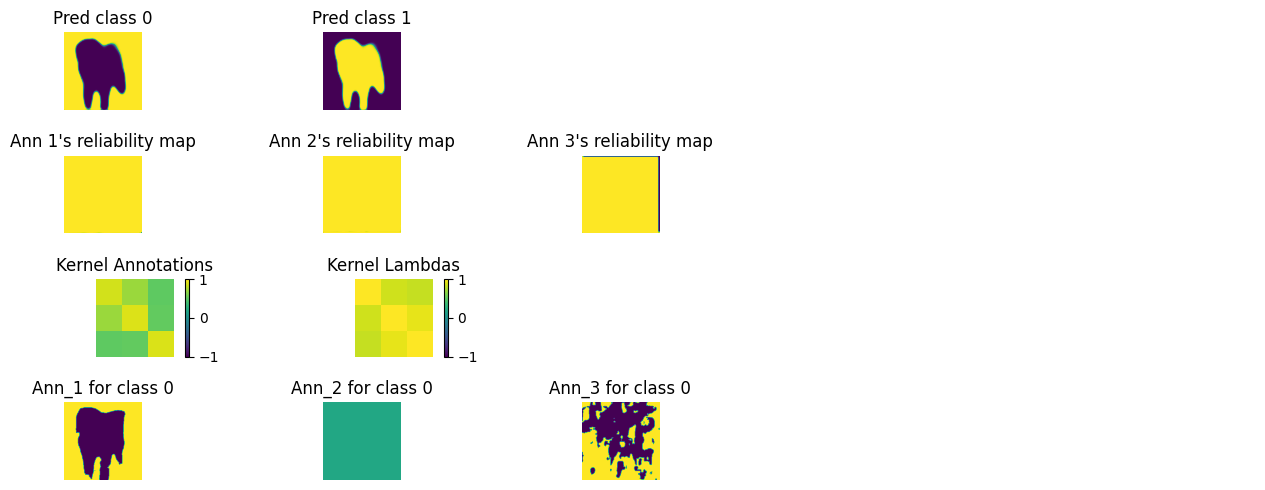

Validation Epoch 5/15: 100%|██████████| 8/8 [00:05<00:00,  1.33it/s]


Train loss: -0.04463 | Time: 3m 48s | TGCE: 0.07683 | RBFKA: 0.05427 | Val loss: -0.01968 | TGCE: 0.09689 | RBFKA: 0.02893
Train_DICE: 0.90867 | Train_Jaccard: 0.83900 | Train_Sensitivity: 0.91572 | Train_Specificity: 0.93978 
Val_DICE: 0.88322 | Val_Jaccard: 0.80034 | Val_Sensitivity: 0.82234 | Val_Specificity: 0.97891 

Epoch 6/15


Validation Epoch 6/15: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train loss: -0.03598 | Time: 4m 33s | TGCE: 0.07581 | RBFKA: 0.04485 | Val loss: -0.03559 | TGCE: 0.09516 | RBFKA: 0.04597
Train_DICE: 0.91390 | Train_Jaccard: 0.84775 | Train_Sensitivity: 0.91706 | Train_Specificity: 0.94524 
Val_DICE: 0.88738 | Val_Jaccard: 0.80788 | Val_Sensitivity: 0.96718 | Val_Specificity: 0.87603 

Epoch 7/15


Validation Epoch 7/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: -0.03085 | Time: 5m 19s | TGCE: 0.07376 | RBFKA: 0.03915 | Val loss: -0.01765 | TGCE: 0.09378 | RBFKA: 0.02650
Train_DICE: 0.91961 | Train_Jaccard: 0.85677 | Train_Sensitivity: 0.92342 | Train_Specificity: 0.94814 
Val_DICE: 0.89920 | Val_Jaccard: 0.82464 | Val_Sensitivity: 0.84821 | Val_Specificity: 0.97872 

Epoch 8/15


Validation Epoch 8/15: 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]


Train loss: -0.02194 | Time: 6m 4s | TGCE: 0.07295 | RBFKA: 0.02947 | Val loss: -0.01398 | TGCE: 0.08906 | RBFKA: 0.02215
Train_DICE: 0.92247 | Train_Jaccard: 0.86145 | Train_Sensitivity: 0.92600 | Train_Specificity: 0.95002 
Val_DICE: 0.91910 | Val_Jaccard: 0.85652 | Val_Sensitivity: 0.90118 | Val_Specificity: 0.96393 

Epoch 9/15


Validation Epoch 9/15: 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]


Train loss: -0.01213 | Time: 6m 49s | TGCE: 0.07124 | RBFKA: 0.01875 | Val loss: -0.01146 | TGCE: 0.08764 | RBFKA: 0.01932
Train_DICE: 0.92805 | Train_Jaccard: 0.87077 | Train_Sensitivity: 0.93127 | Train_Specificity: 0.95202 
Val_DICE: 0.92455 | Val_Jaccard: 0.86611 | Val_Sensitivity: 0.93745 | Val_Specificity: 0.94598 

Epoch 10/15


Training Epoch 10/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


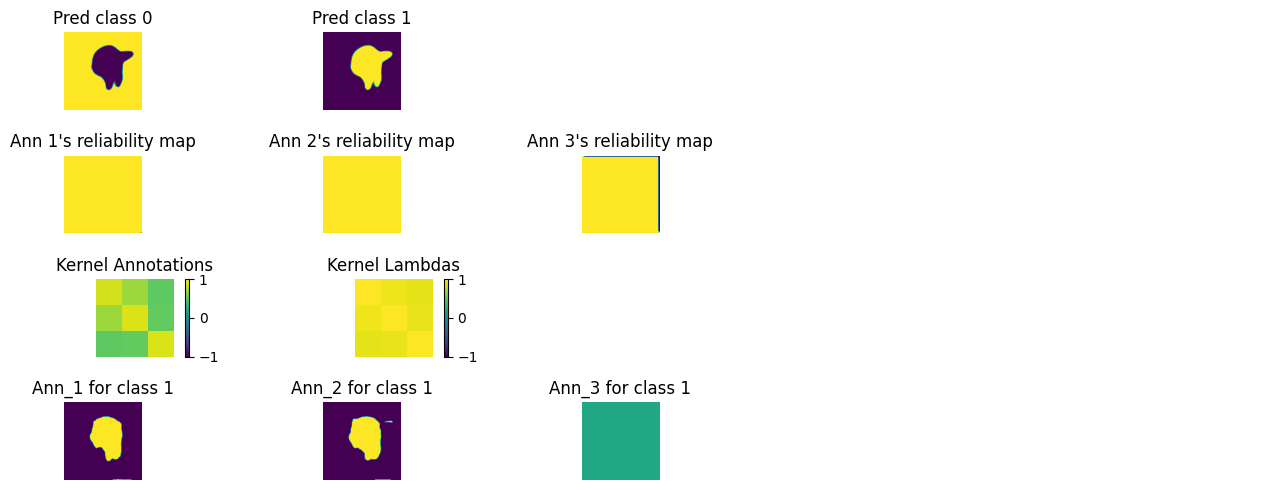

Validation Epoch 10/15: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train loss: -0.01644 | Time: 7m 35s | TGCE: 0.07163 | RBFKA: 0.02343 | Val loss: -0.01144 | TGCE: 0.08813 | RBFKA: 0.01934
Train_DICE: 0.92624 | Train_Jaccard: 0.86777 | Train_Sensitivity: 0.93048 | Train_Specificity: 0.95033 
Val_DICE: 0.92357 | Val_Jaccard: 0.86419 | Val_Sensitivity: 0.92507 | Val_Specificity: 0.95368 

Epoch 11/15


Validation Epoch 11/15: 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]


Train loss: -0.01386 | Time: 8m 20s | TGCE: 0.07042 | RBFKA: 0.02054 | Val loss: -0.01262 | TGCE: 0.08788 | RBFKA: 0.02059
Train_DICE: 0.93125 | Train_Jaccard: 0.87589 | Train_Sensitivity: 0.93398 | Train_Specificity: 0.95447 
Val_DICE: 0.92146 | Val_Jaccard: 0.86155 | Val_Sensitivity: 0.95318 | Val_Specificity: 0.93103 

Epoch 12/15


Validation Epoch 12/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: -0.01840 | Time: 9m 5s | TGCE: 0.06936 | RBFKA: 0.02537 | Val loss: -0.01606 | TGCE: 0.08941 | RBFKA: 0.02443
Train_DICE: 0.93371 | Train_Jaccard: 0.88013 | Train_Sensitivity: 0.93781 | Train_Specificity: 0.95382 
Val_DICE: 0.92104 | Val_Jaccard: 0.85973 | Val_Sensitivity: 0.89232 | Val_Specificity: 0.97303 

Epoch 13/15


Validation Epoch 13/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: -0.02151 | Time: 9m 51s | TGCE: 0.06758 | RBFKA: 0.02858 | Val loss: -0.01677 | TGCE: 0.08521 | RBFKA: 0.02486
Train_DICE: 0.93680 | Train_Jaccard: 0.88532 | Train_Sensitivity: 0.93889 | Train_Specificity: 0.95720 
Val_DICE: 0.92774 | Val_Jaccard: 0.87155 | Val_Sensitivity: 0.93060 | Val_Specificity: 0.95618 

Epoch 14/15


Validation Epoch 14/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: -0.02424 | Time: 10m 36s | TGCE: 0.06555 | RBFKA: 0.03137 | Val loss: -0.02942 | TGCE: 0.08414 | RBFKA: 0.03843
Train_DICE: 0.93778 | Train_Jaccard: 0.88708 | Train_Sensitivity: 0.94108 | Train_Specificity: 0.95625 
Val_DICE: 0.92822 | Val_Jaccard: 0.87253 | Val_Sensitivity: 0.93071 | Val_Specificity: 0.95380 

Epoch 15/15


Training Epoch 15/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


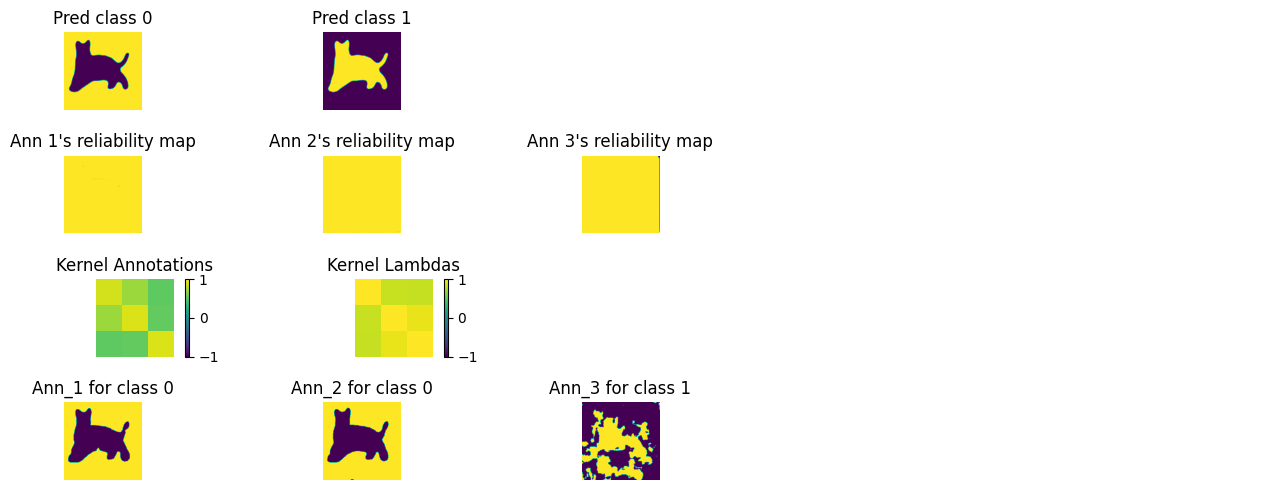

Validation Epoch 15/15: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train loss: -0.04087 | Time: 11m 22s | TGCE: 0.06408 | RBFKA: 0.04920 | Val loss: -0.08632 | TGCE: 0.08421 | RBFKA: 0.09986
Train_DICE: 0.93650 | Train_Jaccard: 0.88498 | Train_Sensitivity: 0.93810 | Train_Specificity: 0.95695 
Val_DICE: 0.92524 | Val_Jaccard: 0.86697 | Val_Sensitivity: 0.90914 | Val_Specificity: 0.96516 


[I 2025-04-23 16:48:23,646] Trial 4 finished with value: 0.925236165523529 and parameters: {'q': 0.9753355514409305, 'alpha_factor': 0.926482256973997, 'sigma': 3.394615915091637e-07}. Best is trial 1 with value: 0.9281929433345795.



¡Entrenamiento finalizado!
Trial 5: Probando parámetros {'q': 0.8668299518479116, 'alpha_factor': 0.14059084146944625, 'sigma': 0.04038457297330837}
Precisión mixta automática (AMP) habilitada

Epoch 1/15


Training Epoch 1/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


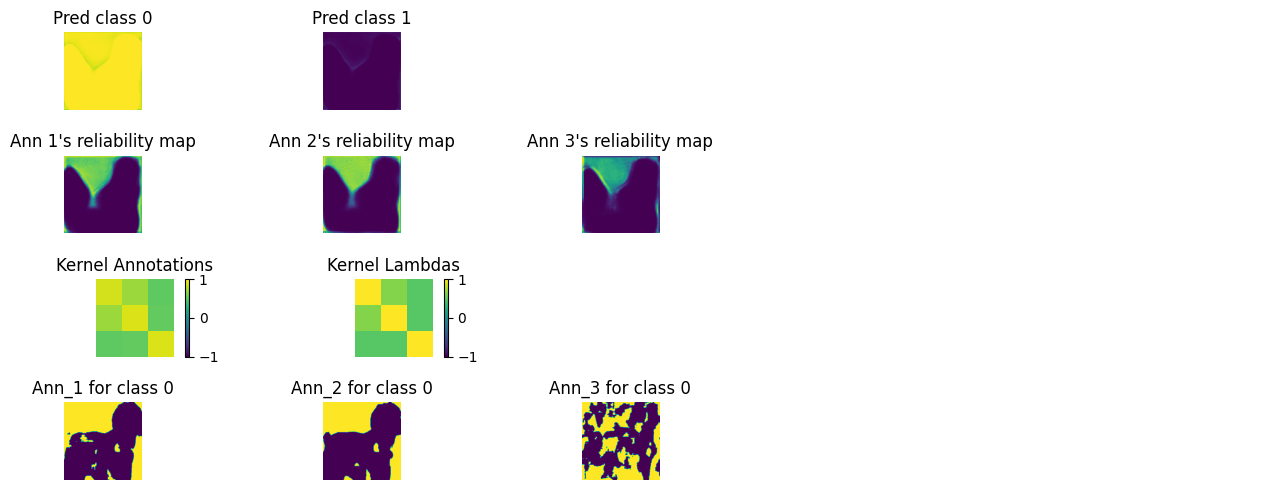

Validation Epoch 1/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: 0.27598 | Time: 0m 46s | TGCE: 0.41855 | RBFKA: 0.59552 | Val loss: 0.22246 | TGCE: 0.38434 | RBFKA: 0.76705
Train_DICE: 0.00294 | Train_Jaccard: 0.00293 | Train_Sensitivity: 0.00000 | Train_Specificity: 0.99994 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 2/15


Validation Epoch 2/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: 0.18083 | Time: 1m 31s | TGCE: 0.31488 | RBFKA: 0.63854 | Val loss: 0.19877 | TGCE: 0.26320 | RBFKA: 0.19504
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 3/15


Validation Epoch 3/15: 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]


Train loss: 0.13553 | Time: 2m 17s | TGCE: 0.26353 | RBFKA: 0.64695 | Val loss: 0.13382 | TGCE: 0.27528 | RBFKA: 0.73087
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 4/15


Validation Epoch 4/15: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train loss: 0.13170 | Time: 3m 3s | TGCE: 0.25981 | RBFKA: 0.65140 | Val loss: 0.16349 | TGCE: 0.25913 | RBFKA: 0.42116
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 5/15


Training Epoch 5/15: 100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


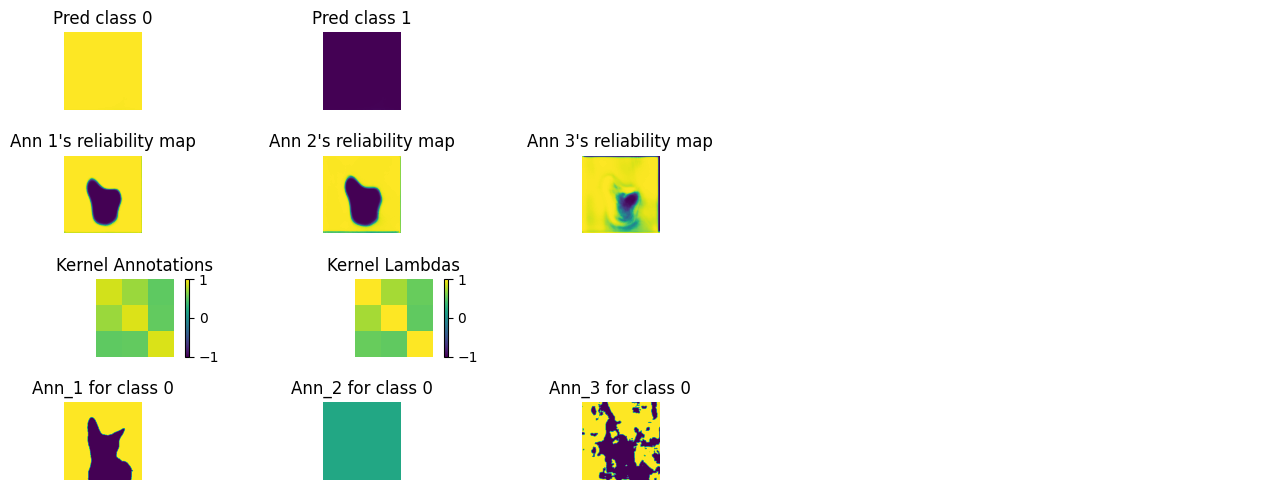

Validation Epoch 5/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: 0.12820 | Time: 3m 49s | TGCE: 0.25692 | RBFKA: 0.65861 | Val loss: 0.12509 | TGCE: 0.26315 | RBFKA: 0.71886
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 6/15


Validation Epoch 6/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: 0.12427 | Time: 4m 35s | TGCE: 0.25611 | RBFKA: 0.68162 | Val loss: 0.14478 | TGCE: 0.25617 | RBFKA: 0.53614
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 


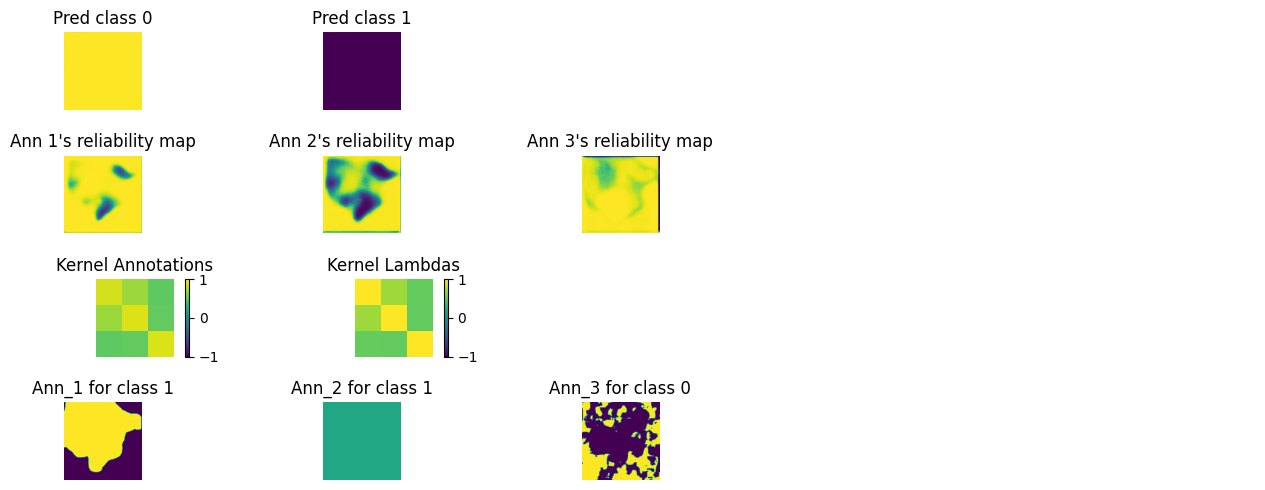

[I 2025-04-23 16:52:59,922] Trial 5 pruned. 


Trial 5 ha sido podado en la época 6
Trial 6: Probando parámetros {'q': 0.9661278572733785, 'alpha_factor': 0.8204886151974184, 'sigma': 0.015878541805547076}
Precisión mixta automática (AMP) habilitada

Epoch 1/15


Training Epoch 1/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


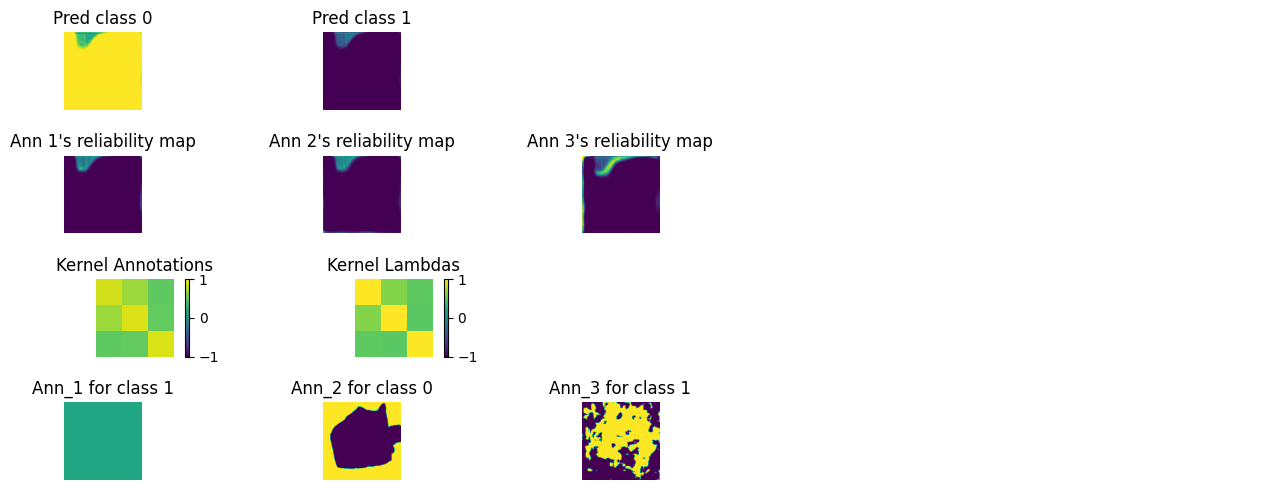

Validation Epoch 1/15: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train loss: -0.37773 | Time: 0m 46s | TGCE: 0.46258 | RBFKA: 0.56158 | Val loss: -0.44039 | TGCE: 0.46718 | RBFKA: 0.63895
Train_DICE: 0.00001 | Train_Jaccard: 0.00000 | Train_Sensitivity: 0.00000 | Train_Specificity: 0.99966 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: 0.00000 | Val_Specificity: 0.99947 

Epoch 2/15


Validation Epoch 2/15: 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]


Train loss: -0.45462 | Time: 1m 33s | TGCE: 0.45585 | RBFKA: 0.65381 | Val loss: -0.39909 | TGCE: 0.45795 | RBFKA: 0.58660
Train_DICE: 0.00001 | Train_Jaccard: 0.00001 | Train_Sensitivity: 0.00001 | Train_Specificity: 0.99951 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: 0.00000 | Val_Specificity: 0.99999 

Epoch 3/15


Validation Epoch 3/15: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train loss: -0.47569 | Time: 2m 18s | TGCE: 0.45092 | RBFKA: 0.67842 | Val loss: -0.34031 | TGCE: 0.43987 | RBFKA: 0.51100
Train_DICE: 0.00000 | Train_Jaccard: 0.00000 | Train_Sensitivity: 0.00000 | Train_Specificity: 0.99989 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: 0.00000 | Val_Specificity: 0.99997 

Epoch 4/15


Validation Epoch 4/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: -0.47502 | Time: 3m 3s | TGCE: 0.44055 | RBFKA: 0.67533 | Val loss: -0.44064 | TGCE: 0.45370 | RBFKA: 0.63631
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: 0.00000 | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 5/15


Training Epoch 5/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


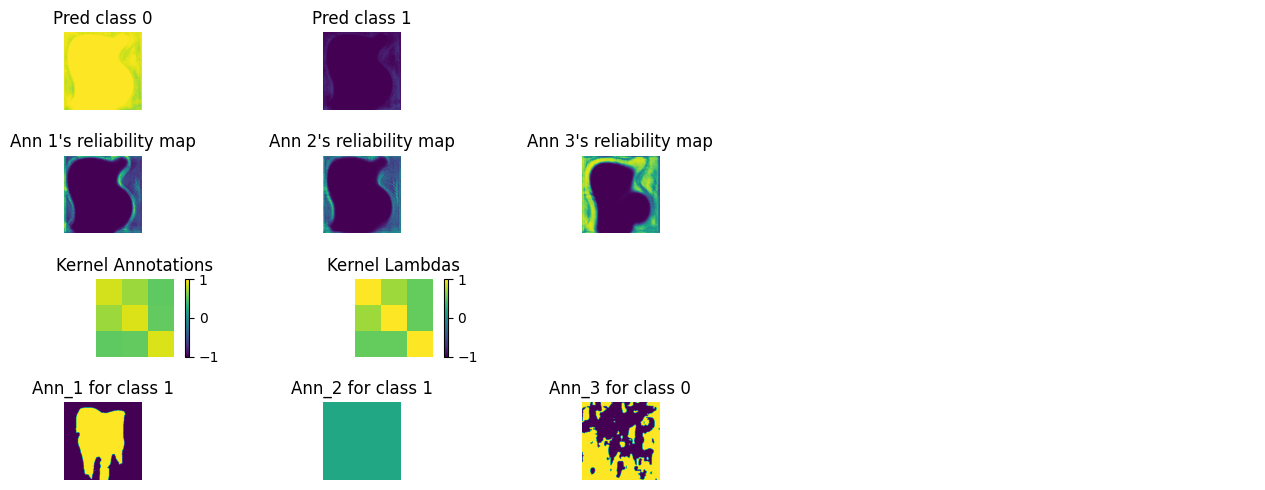

Validation Epoch 5/15: 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]


Train loss: -0.48800 | Time: 3m 49s | TGCE: 0.43819 | RBFKA: 0.69064 | Val loss: -0.43093 | TGCE: 0.43076 | RBFKA: 0.61946
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 

Epoch 6/15


Validation Epoch 6/15: 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]


Train loss: -0.47353 | Time: 4m 34s | TGCE: 0.43044 | RBFKA: 0.67131 | Val loss: -0.54850 | TGCE: 0.43066 | RBFKA: 0.76273
Train_DICE: 0.00293 | Train_Jaccard: 0.00293 | Train_Sensitivity: zero | Train_Specificity: 1.00000 
Val_DICE: 0.00391 | Val_Jaccard: 0.00391 | Val_Sensitivity: zero | Val_Specificity: 1.00000 


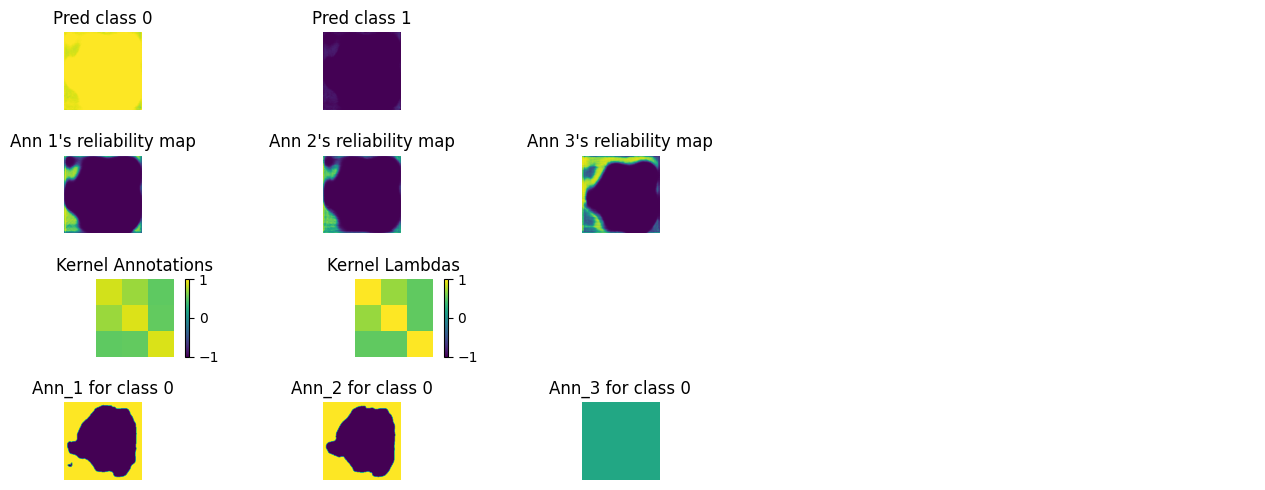

[I 2025-04-23 16:57:35,746] Trial 6 pruned. 


Trial 6 ha sido podado en la época 6
Trial 7: Probando parámetros {'q': 0.44121385435516747, 'alpha_factor': 0.5093441029528507, 'sigma': 9.101080701844111e-06}
Precisión mixta automática (AMP) habilitada

Epoch 1/15


Training Epoch 1/15: 100%|██████████| 32/32 [00:39<00:00,  1.23s/it]


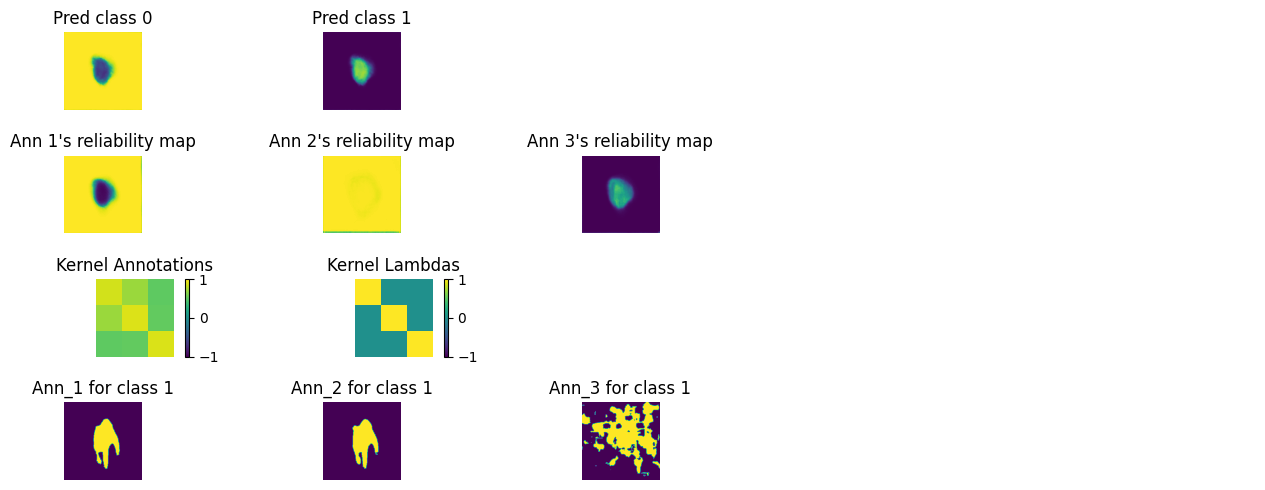

Validation Epoch 1/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: 0.19023 | Time: 0m 47s | TGCE: 0.38781 | RBFKA: 0.00010 | Val loss: 0.15723 | TGCE: 0.32049 | RBFKA: 0.00004
Train_DICE: 0.25116 | Train_Jaccard: 0.20337 | Train_Sensitivity: 0.22277 | Train_Specificity: 0.98173 
Val_DICE: 0.76509 | Val_Jaccard: 0.63389 | Val_Sensitivity: 0.65885 | Val_Specificity: 0.97523 

Epoch 2/15


Validation Epoch 2/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: 0.11749 | Time: 1m 32s | TGCE: 0.24296 | RBFKA: 0.00338 | Val loss: 0.10205 | TGCE: 0.21208 | RBFKA: 0.00395
Train_DICE: 0.87454 | Train_Jaccard: 0.78487 | Train_Sensitivity: 0.88325 | Train_Specificity: 0.92094 
Val_DICE: 0.89198 | Val_Jaccard: 0.81327 | Val_Sensitivity: 0.89718 | Val_Specificity: 0.93276 

Epoch 3/15


Validation Epoch 3/15: 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]


Train loss: 0.04299 | Time: 2m 18s | TGCE: 0.15866 | RBFKA: 0.06843 | Val loss: -0.00651 | TGCE: 0.16551 | RBFKA: 0.17221
Train_DICE: 0.89109 | Train_Jaccard: 0.81118 | Train_Sensitivity: 0.90786 | Train_Specificity: 0.92338 
Val_DICE: 0.88837 | Val_Jaccard: 0.80752 | Val_Sensitivity: 0.84195 | Val_Specificity: 0.97160 

Epoch 4/15


Validation Epoch 4/15: 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]


Train loss: -0.10258 | Time: 3m 5s | TGCE: 0.13523 | RBFKA: 0.33166 | Val loss: -0.08693 | TGCE: 0.15453 | RBFKA: 0.31952
Train_DICE: 0.90241 | Train_Jaccard: 0.82911 | Train_Sensitivity: 0.90804 | Train_Specificity: 0.93776 
Val_DICE: 0.90482 | Val_Jaccard: 0.83424 | Val_Sensitivity: 0.93164 | Val_Specificity: 0.92638 

Epoch 5/15


Training Epoch 5/15: 100%|██████████| 32/32 [00:39<00:00,  1.24s/it]


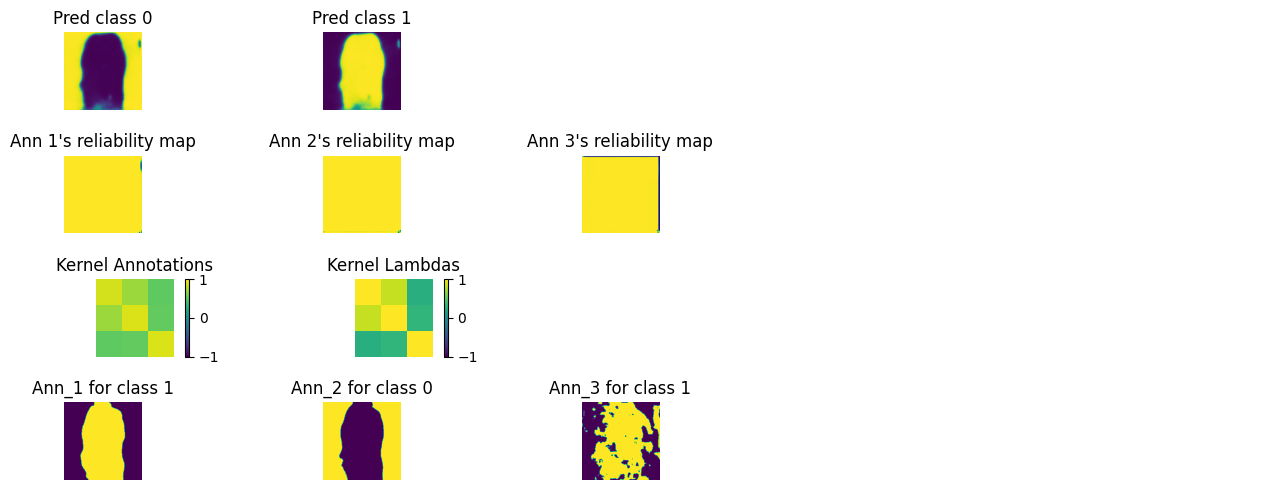

Validation Epoch 5/15: 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]


Train loss: -0.05009 | Time: 3m 51s | TGCE: 0.13174 | RBFKA: 0.22525 | Val loss: -0.01866 | TGCE: 0.15015 | RBFKA: 0.18127
Train_DICE: 0.90897 | Train_Jaccard: 0.83944 | Train_Sensitivity: 0.91430 | Train_Specificity: 0.94158 
Val_DICE: 0.91540 | Val_Jaccard: 0.85102 | Val_Sensitivity: 0.92155 | Val_Specificity: 0.94562 

Epoch 6/15


Training Epoch 6/15:  66%|██████▌   | 21/32 [00:26<00:12,  1.17s/it]

In [ ]:
optimizing_model = Annot_Harmony_Optimization(train_loader=train_dataset,valid_loader=valid_dataset,config=config)
optimizing_model.start()

In [ ]:
import sqlite3

# Conecta a la base de datos
conn = sqlite3.connect('/kaggle/working/results/optuna_studies.db')  # Reemplaza con el nombre de tu archivo .db
cursor = conn.cursor()

# Listar tablas
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("Tablas en la base de datos:")
for table in tables:
    print(table[0])

# Ver contenido y estructura de una tabla específica
if tables:
    table_name = tables[0][0]  # Usa la primera tabla encontrada

    # Ver contenido
    cursor.execute(f"SELECT * FROM {table_name};")
    rows = cursor.fetchall()
    print(f"\nContenido de la tabla '{table_name}':")
    for row in rows:
        print(row)

    # Ver estructura
    cursor.execute(f"PRAGMA table_info({table_name});")
    columns = cursor.fetchall()
    print(f"\nEstructura de la tabla '{table_name}':")
    for column in columns:
        print(f"Nombre: {column[1]}, Tipo: {column[2]}, Clave primaria: {column[3] != 0}")

# Cierra la conexión                                                
conn.close()